# GAN with KL Divergence & mode coverage metrics

In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import keras.models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from google.colab import files

from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

Using TensorFlow backend.


In [0]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

## Weights and Placeholders

In [0]:
X = tf.placeholder(tf.float32, shape=[None, 2])

D_W1 = tf.Variable(xavier_init([2, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

Z = tf.placeholder(tf.float32, shape=[None, 100])

G_W1 = tf.Variable(xavier_init([100, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 784]))
G_b2 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

## Load Data

In [0]:
mb_size = 128
Z_dim = 100
n_classes = 10

In [0]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Pretrained Classifier
(for convergence metrics)

In [0]:
(x_sample, y_sample) = mnist.train.next_batch(60000)

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_sample, y_sample)

(x_val, y_val) = mnist.validation.next_batch(1000)

score = knn_model.score(x_val, y_val)
print("accuracy=%.2f%%" % (score * 100))

accuracy=96.80%


In [0]:
distr = tf.contrib.distributions

def prob_distr(img_batch):
  img_classes = knn_model.predict(img_batch)
  totals = np.sum(img_classes, axis=0)
  return totals/np.sum(totals)

def kl_divergence(img_batch):
  
  #prob distr of samples
  gen_pd = prob_distr(img_batch) 
  
  # number of modes covered in samples
  modes_covered = sum(1 for p in gen_pd if p > 0) 
  
  # kl divergence
  tiny_e = 1e-5
  gen_pd_epsilon = gen_pd + tiny_e
  data_pd = np.full((n_classes,),(1/n_classes)) + tiny_e
  kl = np.sum(gen_pd_epsilon * np.log(gen_pd_epsilon / data_pd)) 
  rev_kl = np.sum(data_pd * np.log(data_pd / gen_pd_epsilon)) 
  
  return kl, rev_kl, gen_pd, modes_covered

## Model 

### Architectures

In [0]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


def plot(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(10, 10)
    gs.update(wspace=0.1, hspace=0.1)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

### Loss functions

In [0]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

#KL = distr.kl_divergence(distr.Categorical(probs=prob_distr(G_sample)), distr.Categorical(probs= np.full((n_classes,),(1/n_classes))), allow_nan_stats=True)

## Training Session

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
if not os.path.exists('out/'):
    os.makedirs('out/')

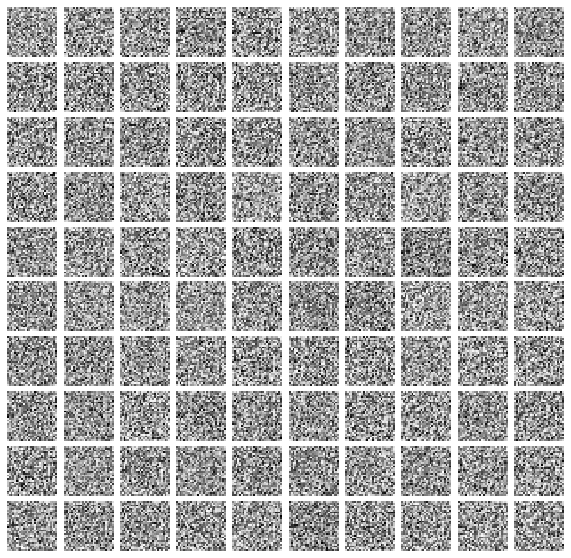

Iter: 0
D loss: 1.216
G_loss: 3.014
KL Div: 0.8561
Reverse KL Div: 3.685



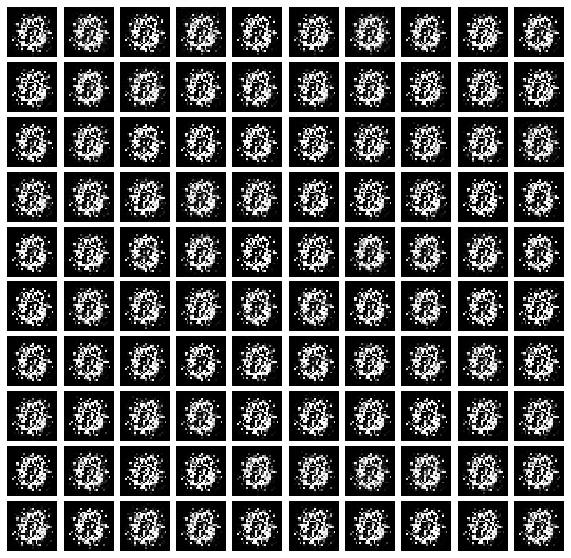

Iter: 1000
D loss: 0.006857
G_loss: 7.196
KL Div: 2.302
Reverse KL Div: 8.06



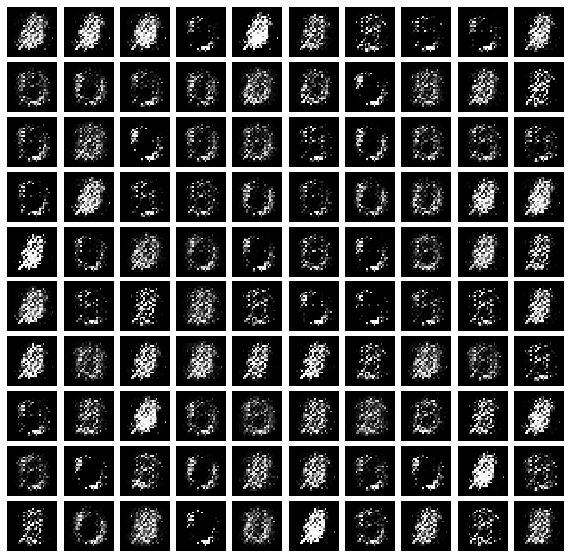

Iter: 2000
D loss: 0.03198
G_loss: 5.227
KL Div: 1.286
Reverse KL Div: 4.028



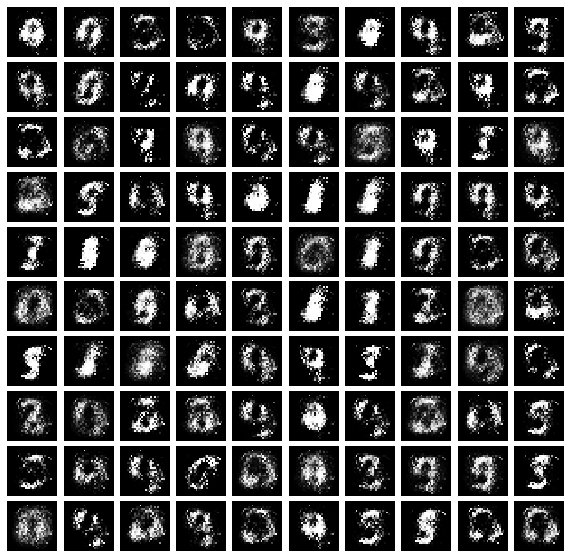

Iter: 3000
D loss: 0.05098
G_loss: 6.297
KL Div: 0.1251
Reverse KL Div: 0.183



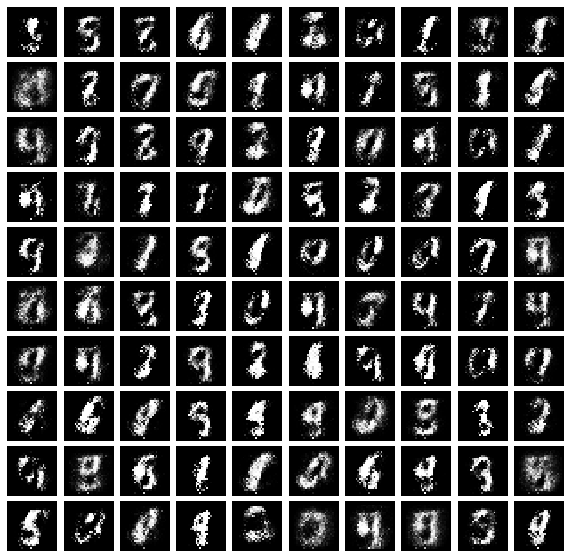

Iter: 4000
D loss: 0.221
G_loss: 5.281
KL Div: 0.3197
Reverse KL Div: 0.3751



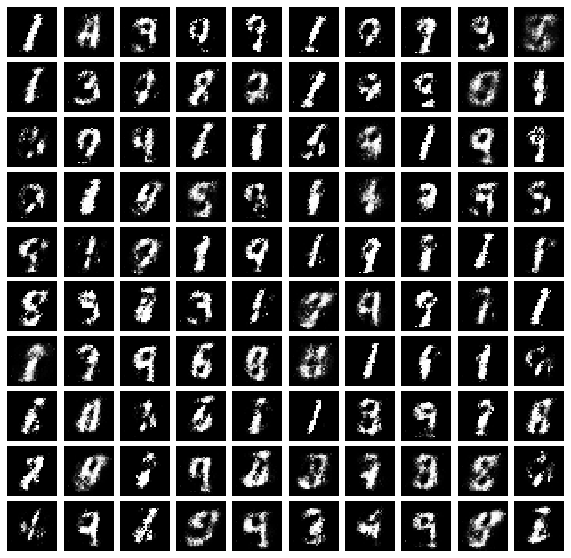

Iter: 5000
D loss: 0.3593
G_loss: 4.0
KL Div: 0.4379
Reverse KL Div: 0.4742



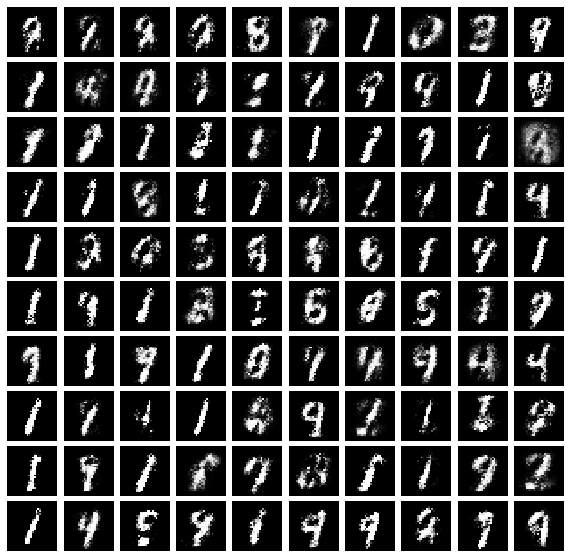

Iter: 6000
D loss: 0.2532
G_loss: 4.477
KL Div: 0.7422
Reverse KL Div: 1.337



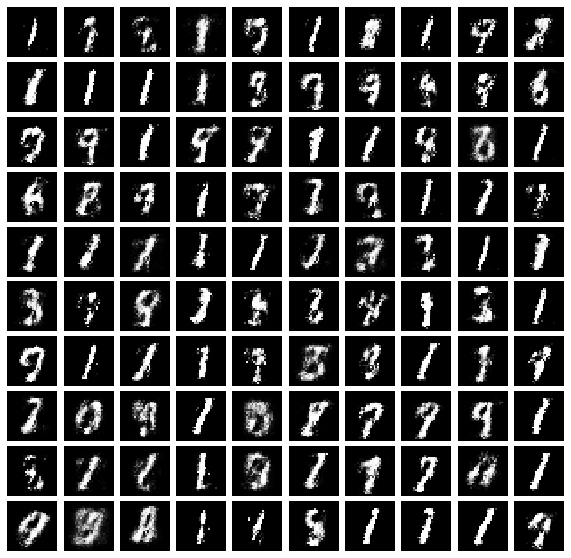

Iter: 7000
D loss: 0.4255
G_loss: 3.505
KL Div: 0.7216
Reverse KL Div: 0.7923



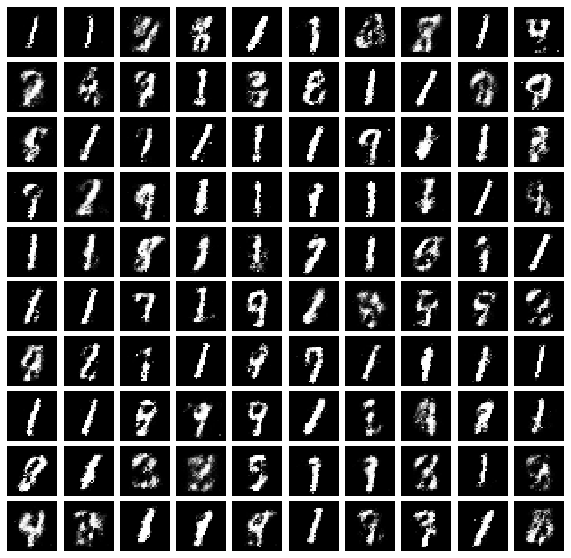

Iter: 8000
D loss: 0.5013
G_loss: 2.689
KL Div: 0.919
Reverse KL Div: 1.687



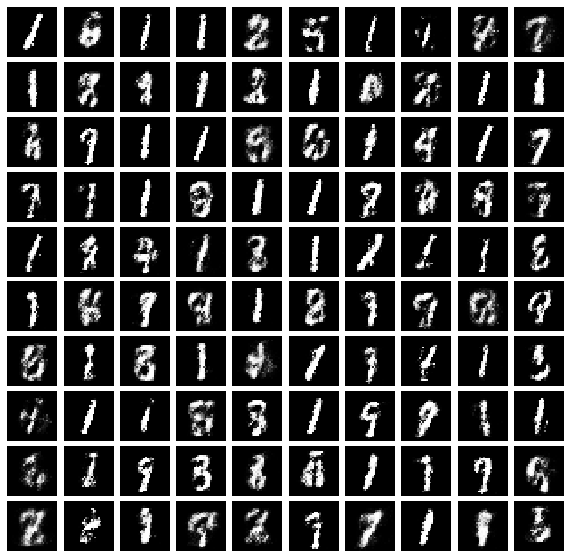

Iter: 9000
D loss: 0.6216
G_loss: 2.516
KL Div: 0.923
Reverse KL Div: 0.9186



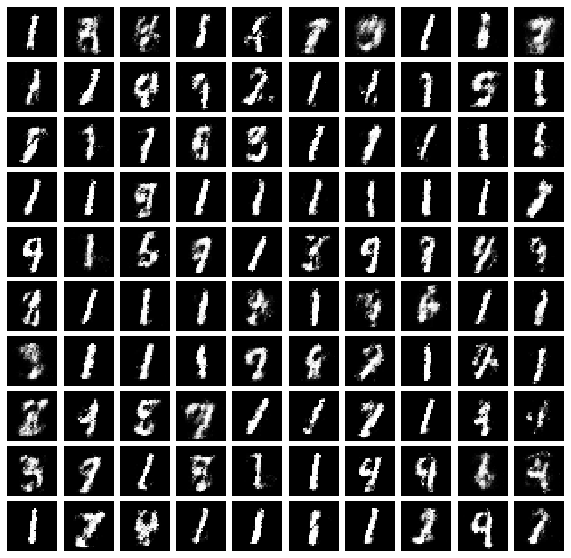

Iter: 10000
D loss: 0.5238
G_loss: 2.818
KL Div: 0.906
Reverse KL Div: 0.9913



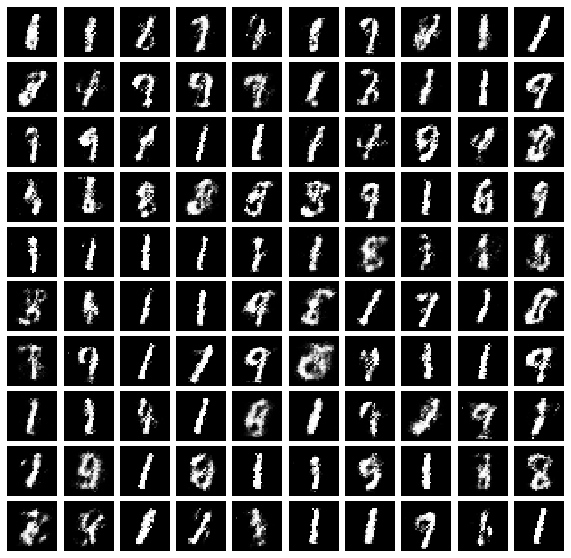

Iter: 11000
D loss: 0.3345
G_loss: 3.578
KL Div: 0.676
Reverse KL Div: 0.6471



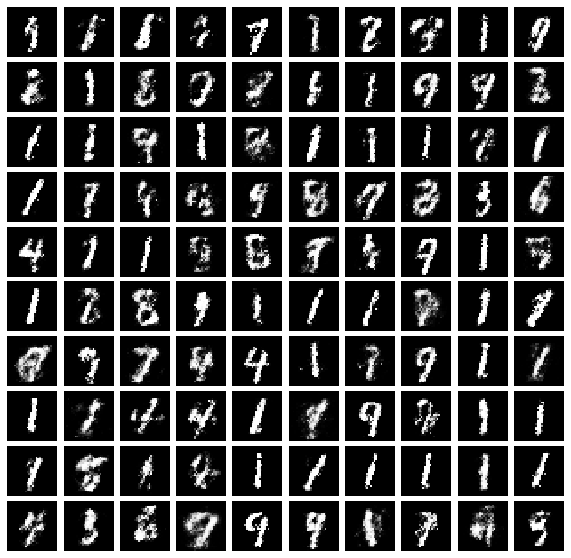

Iter: 12000
D loss: 0.5181
G_loss: 3.047
KL Div: 0.6978
Reverse KL Div: 0.7332



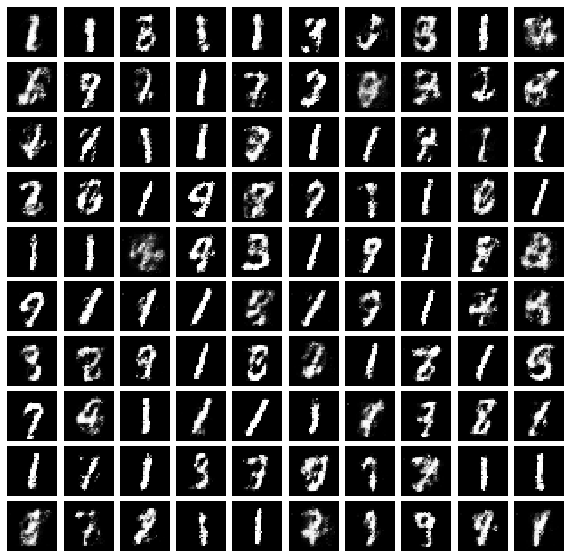

Iter: 13000
D loss: 0.6833
G_loss: 2.488
KL Div: 0.7041
Reverse KL Div: 0.7657



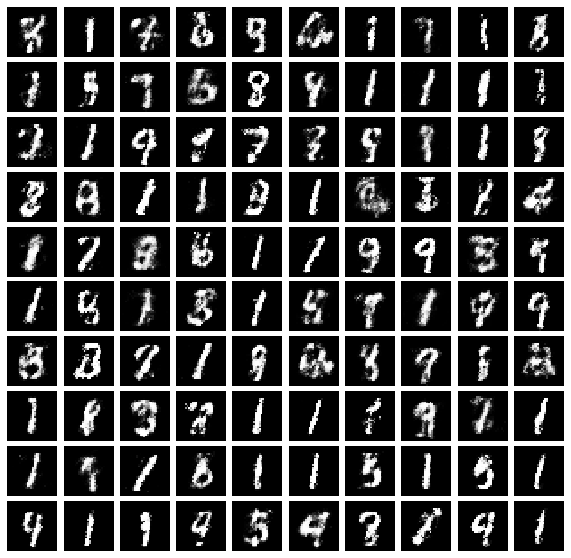

Iter: 14000
D loss: 0.6344
G_loss: 2.8
KL Div: 0.686
Reverse KL Div: 0.7322



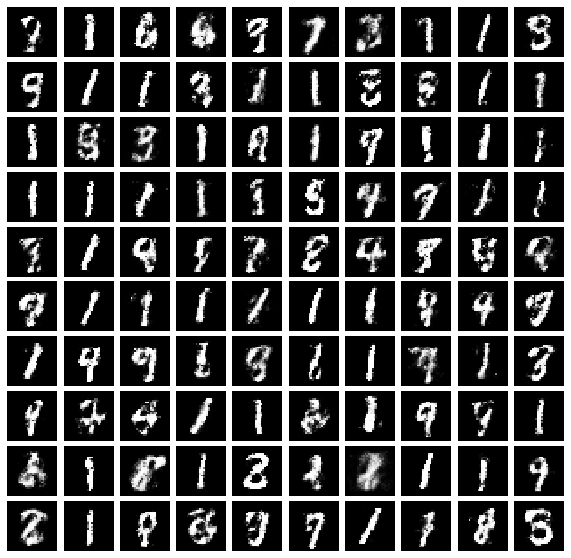

Iter: 15000
D loss: 0.6261
G_loss: 2.402
KL Div: 0.7377
Reverse KL Div: 0.7784



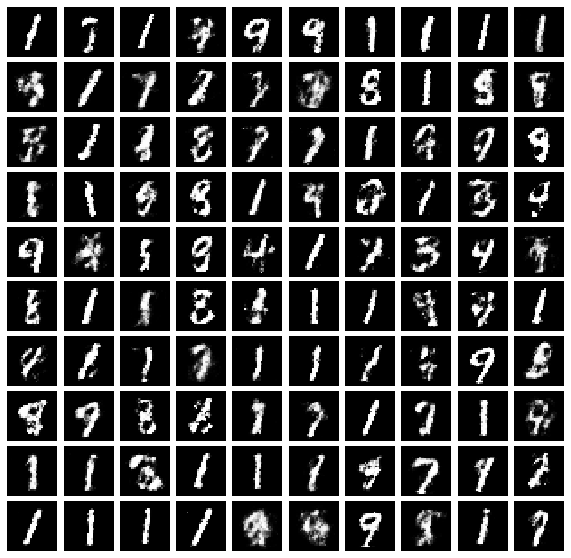

Iter: 16000
D loss: 0.6395
G_loss: 2.372
KL Div: 0.6588
Reverse KL Div: 0.6456



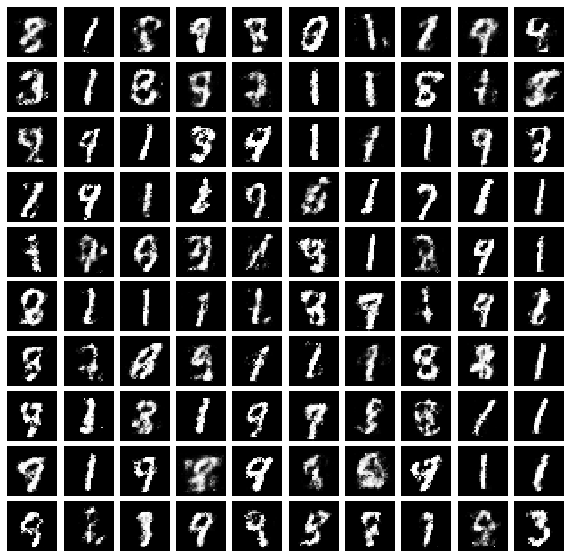

Iter: 17000
D loss: 0.4464
G_loss: 2.558
KL Div: 0.6172
Reverse KL Div: 0.687



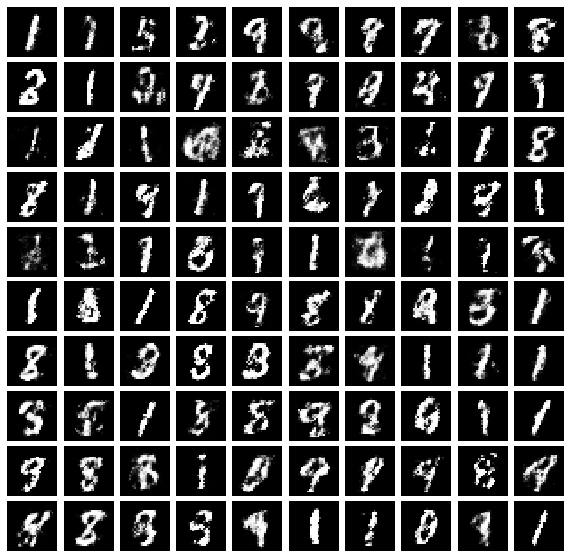

Iter: 18000
D loss: 0.6951
G_loss: 2.248
KL Div: 0.4949
Reverse KL Div: 0.5232



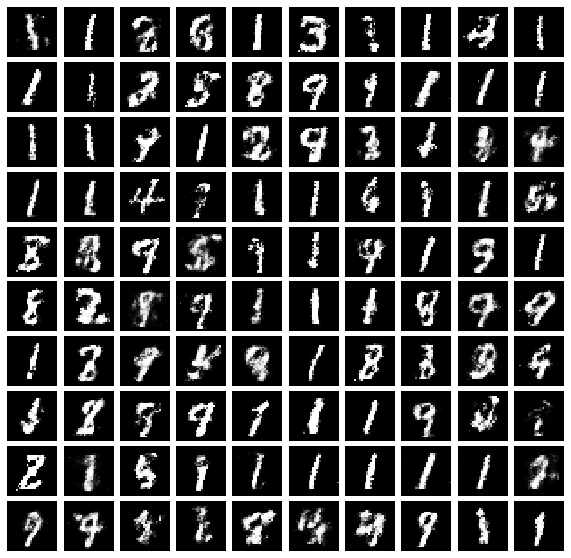

Iter: 19000
D loss: 0.6034
G_loss: 2.134
KL Div: 0.577
Reverse KL Div: 0.6023



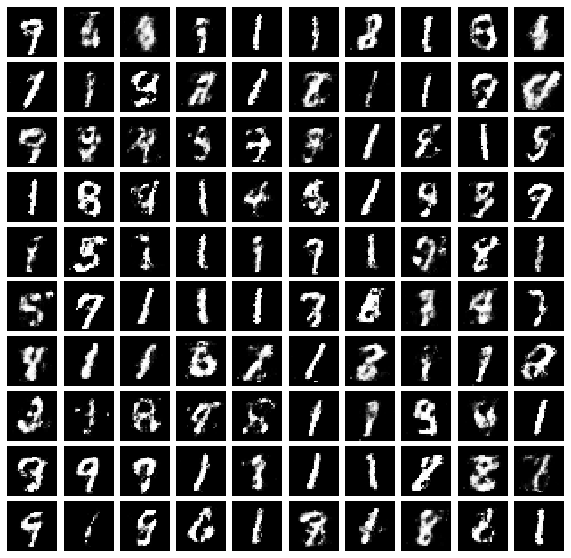

Iter: 20000
D loss: 0.6456
G_loss: 2.497
KL Div: 0.5625
Reverse KL Div: 0.6453



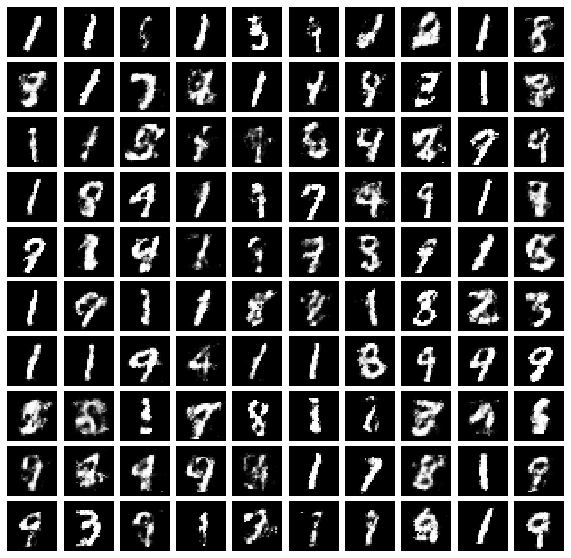

Iter: 21000
D loss: 0.8963
G_loss: 2.215
KL Div: 0.5643
Reverse KL Div: 0.6929



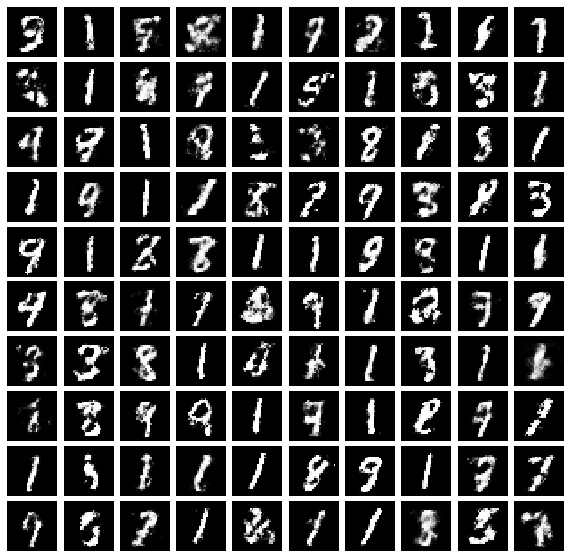

Iter: 22000
D loss: 0.7291
G_loss: 2.467
KL Div: 0.5056
Reverse KL Div: 1.158



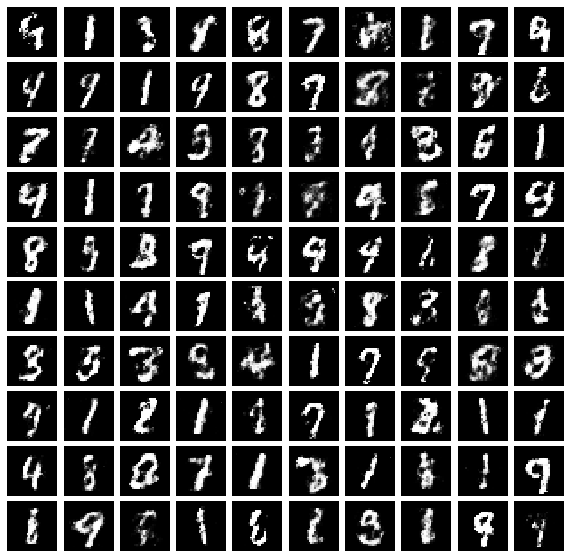

Iter: 23000
D loss: 0.7566
G_loss: 2.469
KL Div: 0.3799
Reverse KL Div: 0.4946



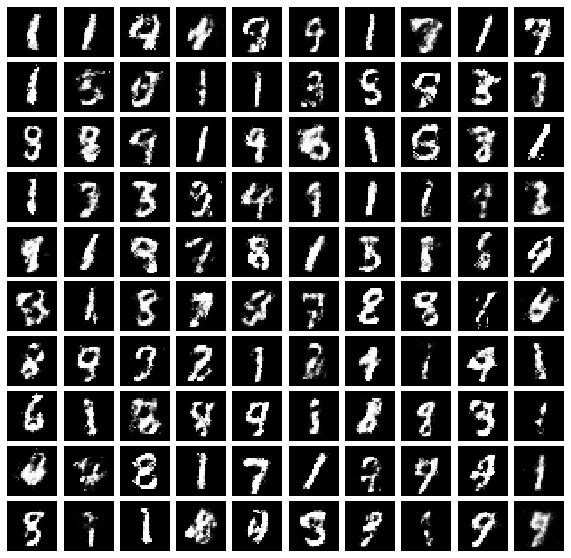

Iter: 24000
D loss: 0.8773
G_loss: 2.192
KL Div: 0.4073
Reverse KL Div: 0.5728



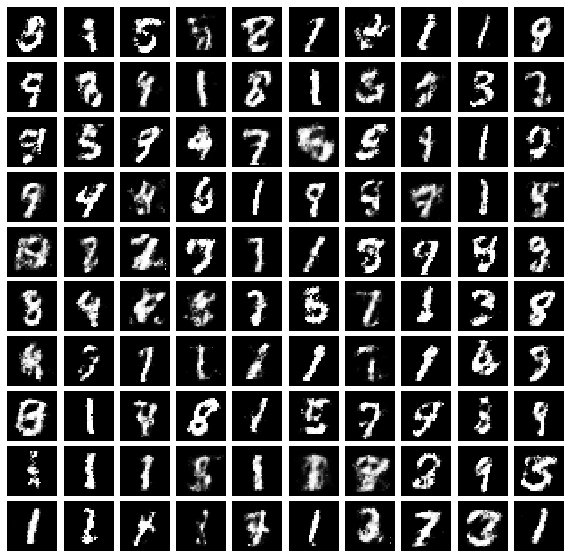

Iter: 25000
D loss: 0.7601
G_loss: 1.988
KL Div: 0.4222
Reverse KL Div: 0.4423



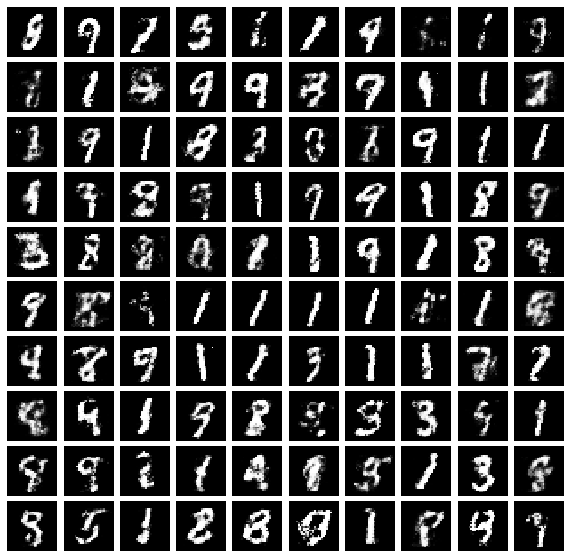

Iter: 26000
D loss: 0.4987
G_loss: 2.558
KL Div: 0.385
Reverse KL Div: 0.4407



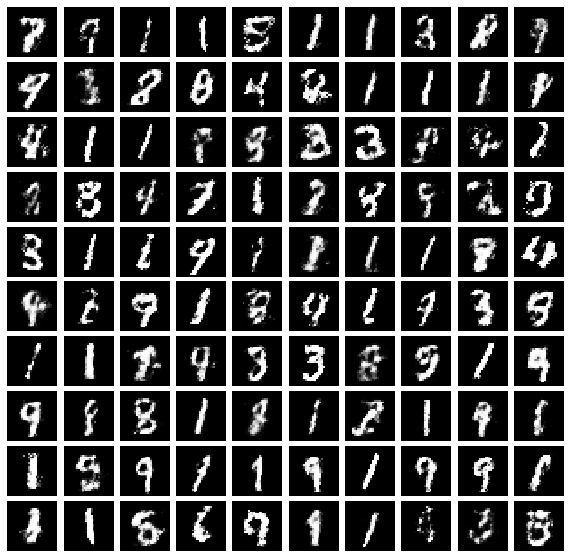

Iter: 27000
D loss: 0.7533
G_loss: 2.24
KL Div: 0.4456
Reverse KL Div: 0.4672



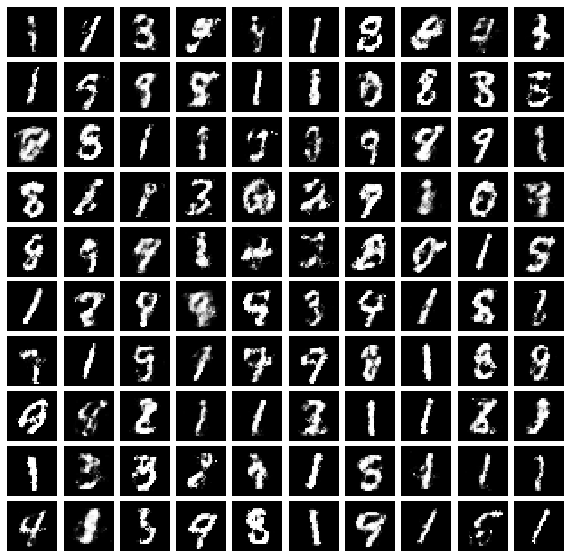

Iter: 28000
D loss: 0.7007
G_loss: 2.401
KL Div: 0.3879
Reverse KL Div: 0.4456



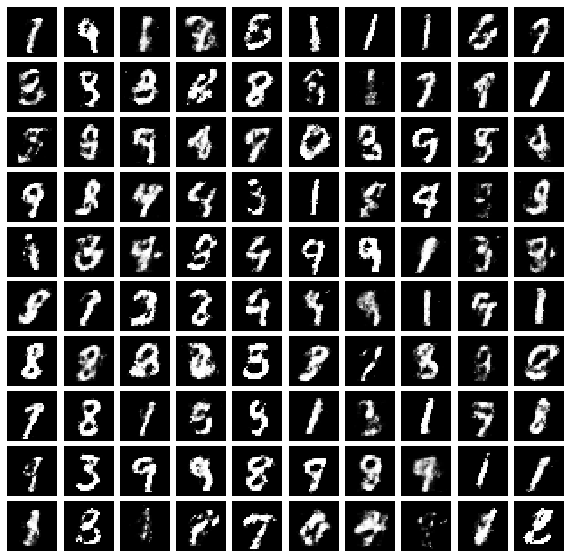

Iter: 29000
D loss: 0.5748
G_loss: 2.5
KL Div: 0.3407
Reverse KL Div: 0.4271



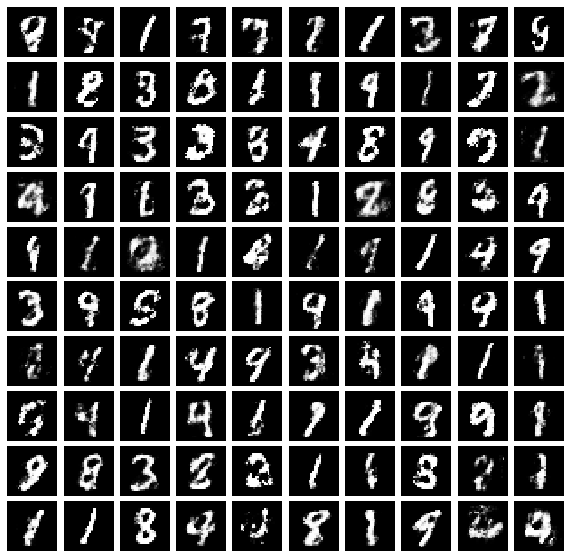

Iter: 30000
D loss: 0.6321
G_loss: 1.97
KL Div: 0.38
Reverse KL Div: 0.4143



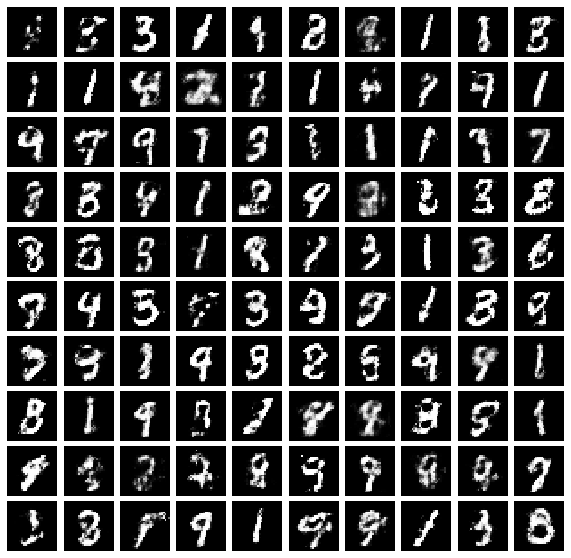

Iter: 31000
D loss: 0.7729
G_loss: 2.543
KL Div: 0.4883
Reverse KL Div: 1.199



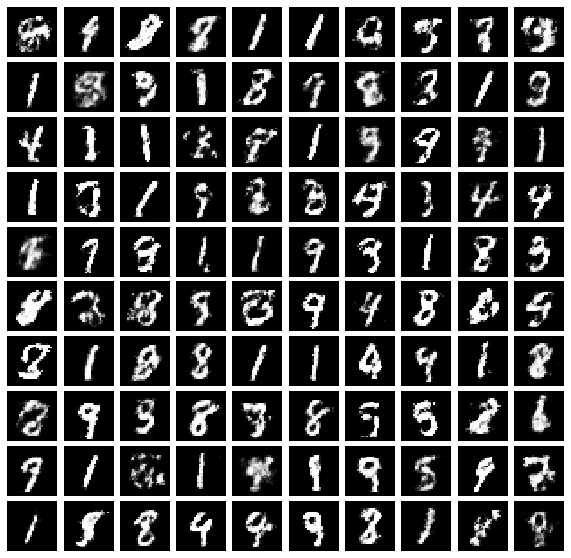

Iter: 32000
D loss: 0.6846
G_loss: 2.279
KL Div: 0.4038
Reverse KL Div: 0.4465



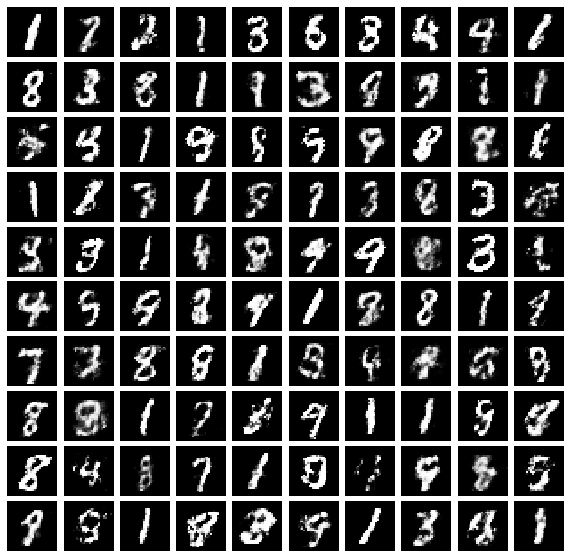

Iter: 33000
D loss: 0.5658
G_loss: 2.203
KL Div: 0.4038
Reverse KL Div: 0.4562



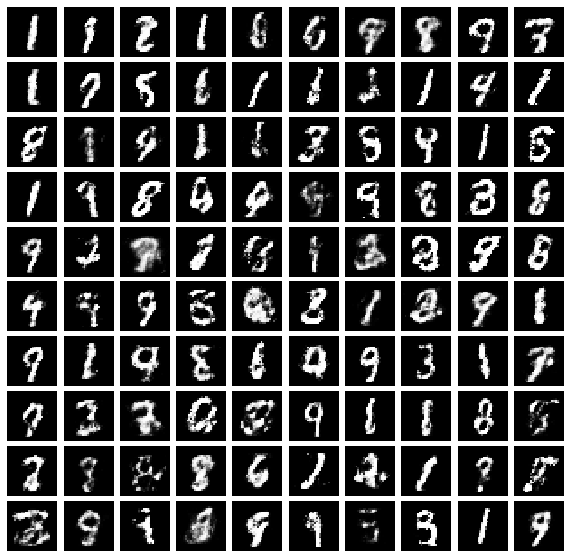

Iter: 34000
D loss: 0.6341
G_loss: 2.313
KL Div: 0.3156
Reverse KL Div: 0.3853



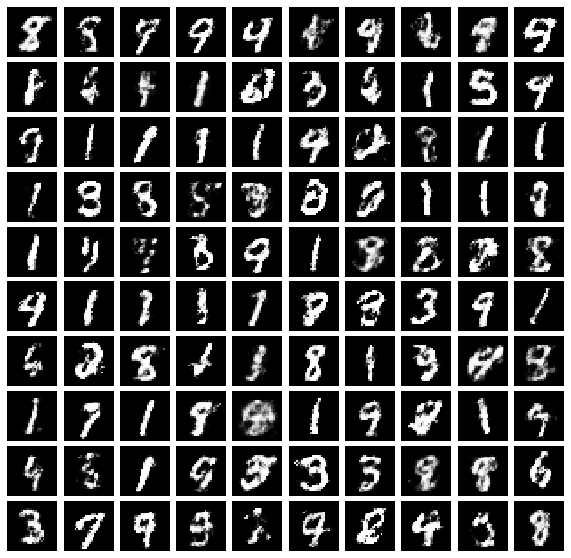

Iter: 35000
D loss: 0.5112
G_loss: 2.392
KL Div: 0.4226
Reverse KL Div: 0.4493



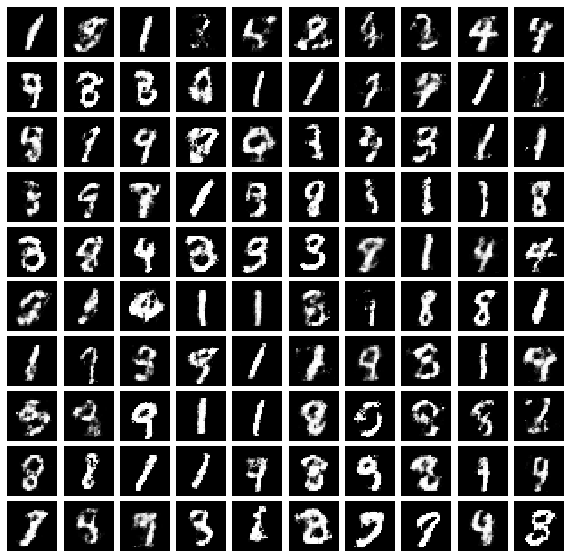

Iter: 36000
D loss: 0.7731
G_loss: 2.225
KL Div: 0.4163
Reverse KL Div: 0.4469



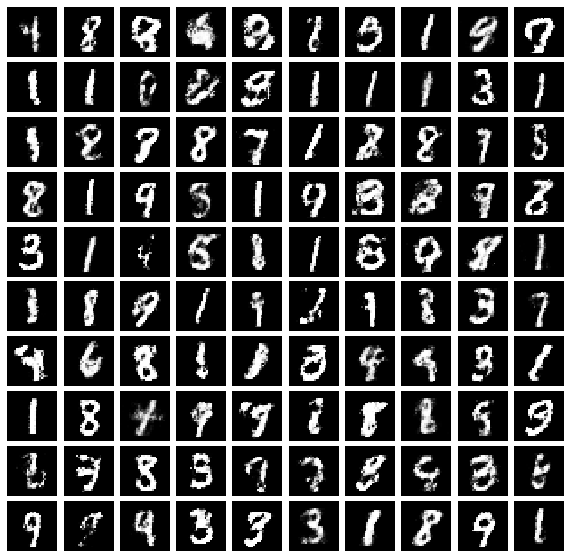

Iter: 37000
D loss: 0.6643
G_loss: 2.288
KL Div: 0.3362
Reverse KL Div: 0.41



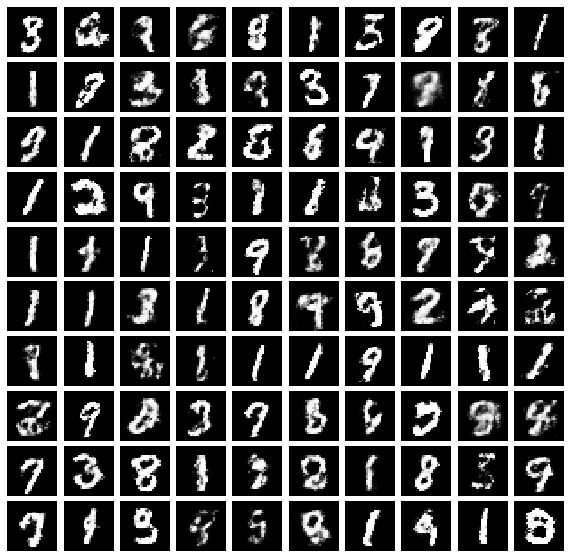

Iter: 38000
D loss: 0.6625
G_loss: 2.449
KL Div: 0.3269
Reverse KL Div: 0.3859



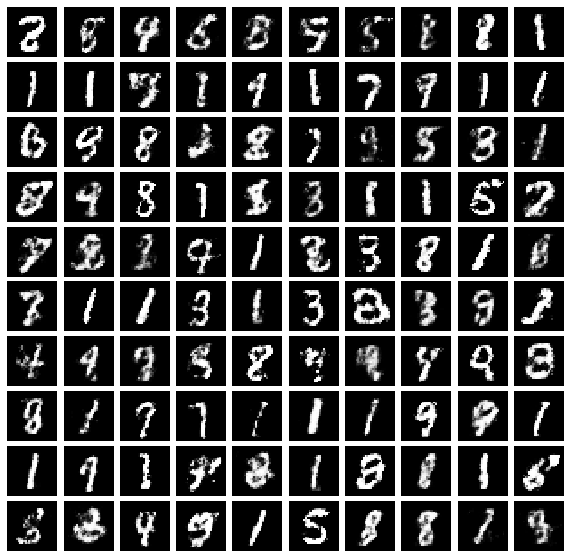

Iter: 39000
D loss: 0.5581
G_loss: 2.236
KL Div: 0.3723
Reverse KL Div: 0.3656



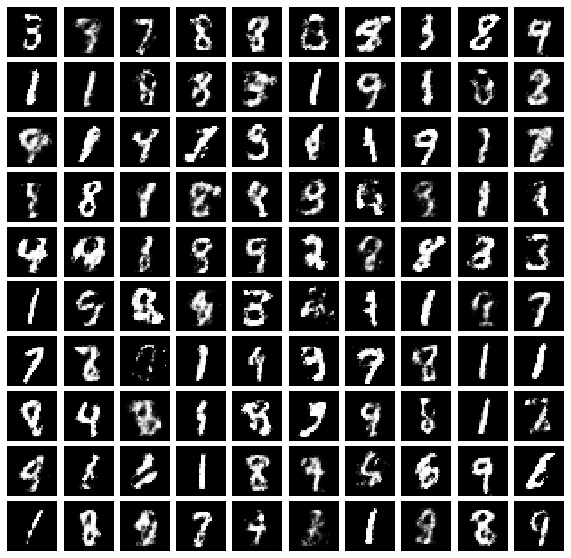

Iter: 40000
D loss: 0.6728
G_loss: 2.348
KL Div: 0.3509
Reverse KL Div: 0.3872



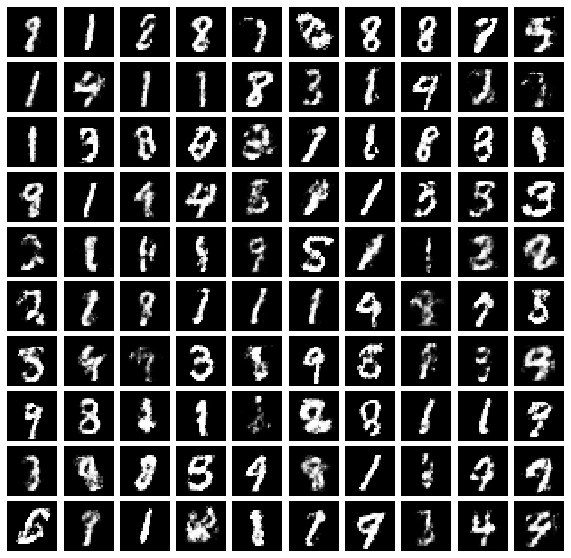

Iter: 41000
D loss: 0.7236
G_loss: 2.412
KL Div: 0.4448
Reverse KL Div: 0.499



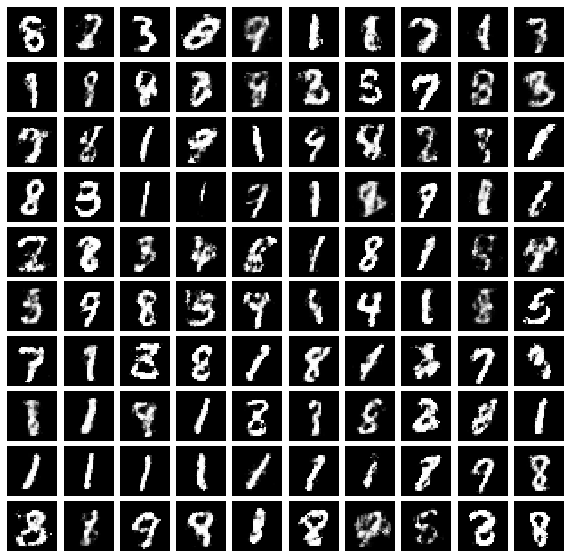

Iter: 42000
D loss: 0.7548
G_loss: 2.525
KL Div: 0.475
Reverse KL Div: 0.6768



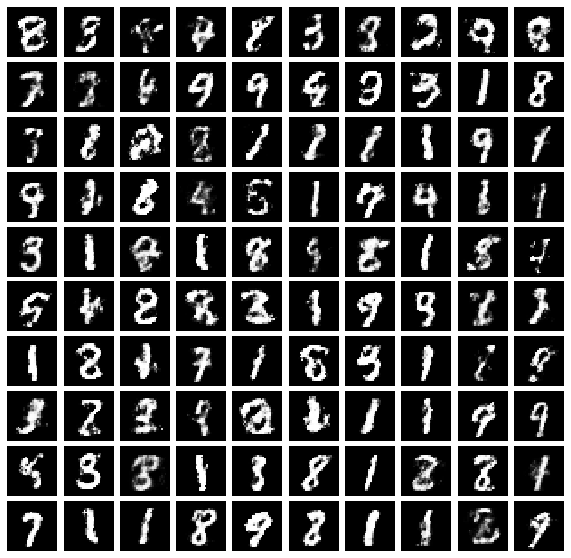

Iter: 43000
D loss: 0.6626
G_loss: 2.354
KL Div: 0.4271
Reverse KL Div: 0.5141



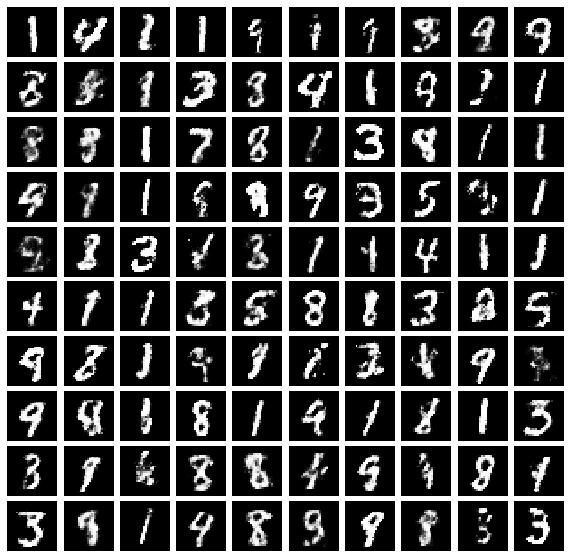

Iter: 44000
D loss: 0.6863
G_loss: 2.197
KL Div: 0.2801
Reverse KL Div: 0.3273



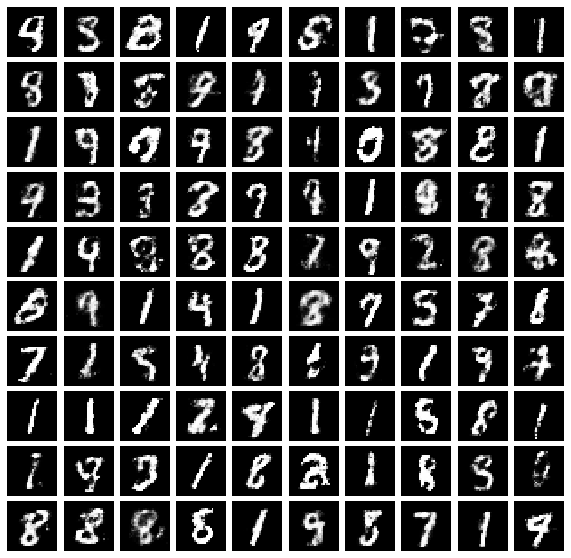

Iter: 45000
D loss: 0.6595
G_loss: 2.296
KL Div: 0.3509
Reverse KL Div: 0.4338



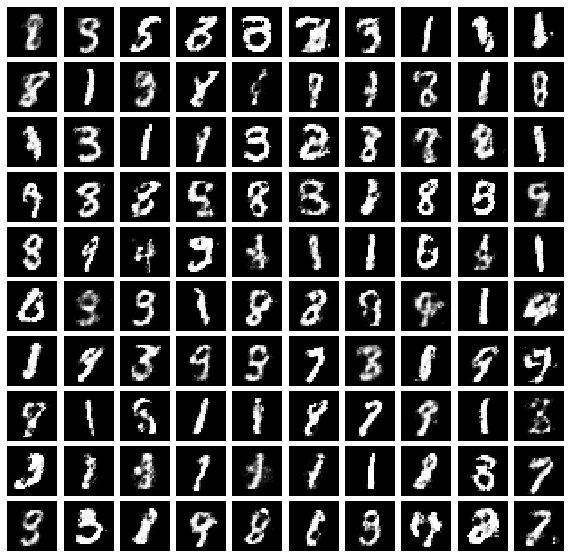

Iter: 46000
D loss: 0.5049
G_loss: 2.476
KL Div: 0.3197
Reverse KL Div: 0.3382



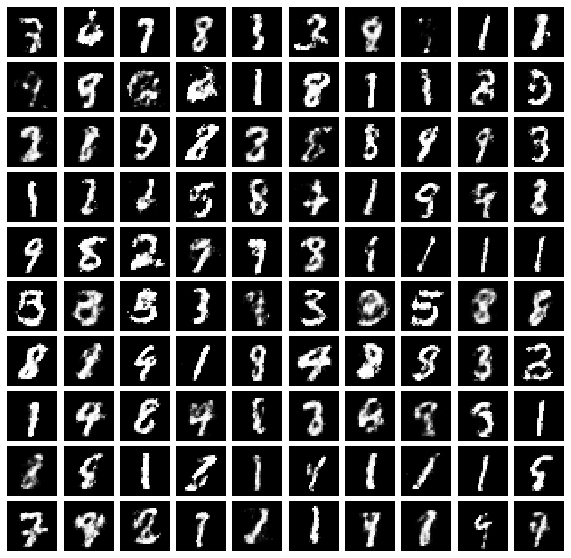

Iter: 47000
D loss: 0.6634
G_loss: 2.155
KL Div: 0.3409
Reverse KL Div: 0.3805



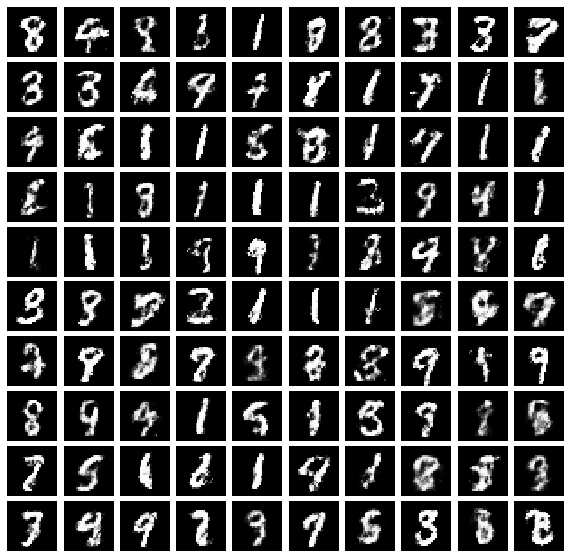

Iter: 48000
D loss: 0.6948
G_loss: 2.016
KL Div: 0.3668
Reverse KL Div: 0.424



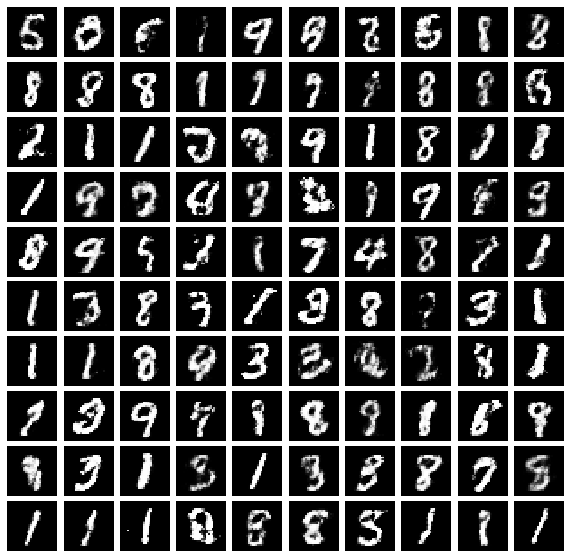

Iter: 49000
D loss: 0.7624
G_loss: 1.963
KL Div: 0.3378
Reverse KL Div: 0.3503



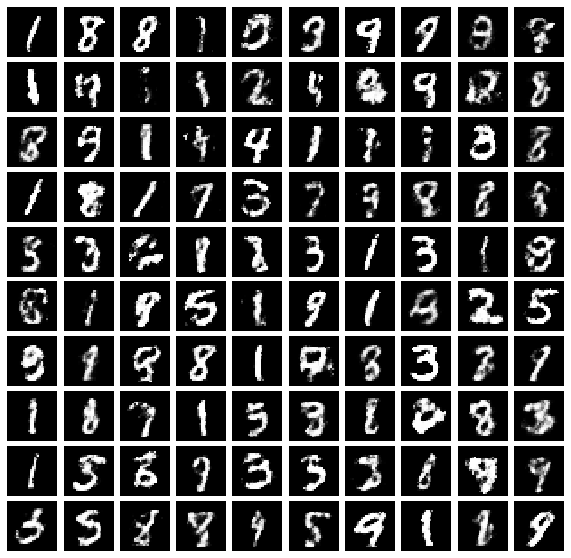

Iter: 50000
D loss: 0.5445
G_loss: 2.242
KL Div: 0.4118
Reverse KL Div: 0.4495



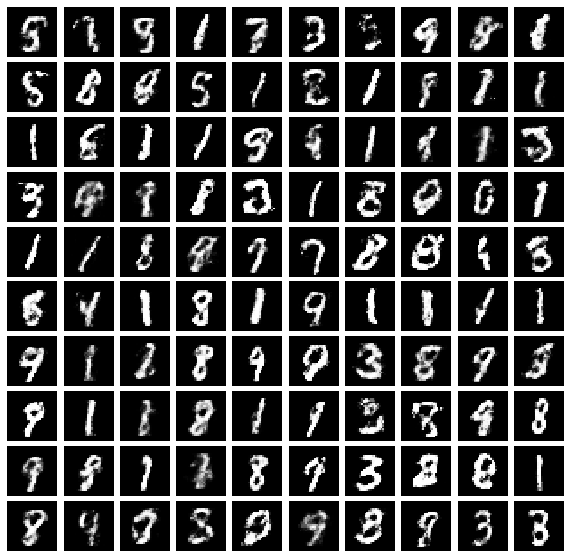

Iter: 51000
D loss: 0.7209
G_loss: 2.252
KL Div: 0.3144
Reverse KL Div: 0.3751



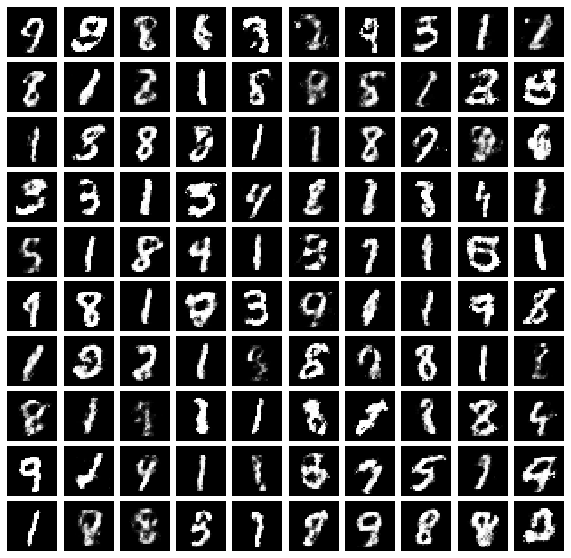

Iter: 52000
D loss: 0.7552
G_loss: 2.382
KL Div: 0.4103
Reverse KL Div: 1.136



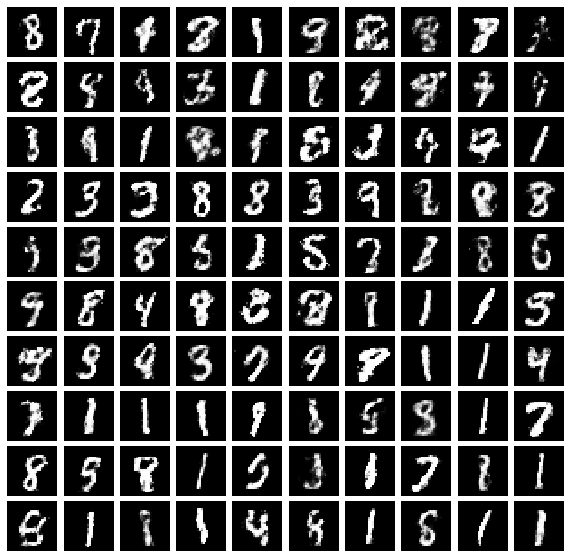

Iter: 53000
D loss: 0.7139
G_loss: 2.237
KL Div: 0.4395
Reverse KL Div: 0.5481



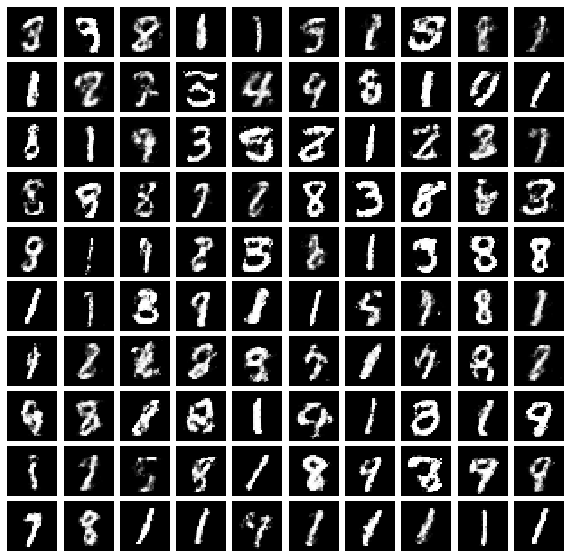

Iter: 54000
D loss: 0.6571
G_loss: 1.951
KL Div: 0.5082
Reverse KL Div: 0.6045



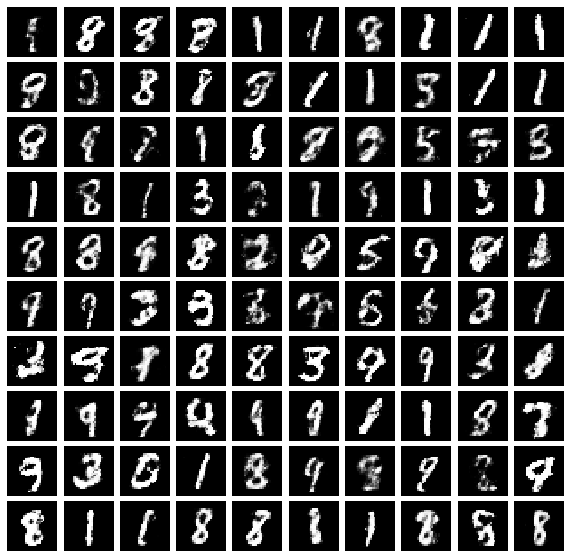

Iter: 55000
D loss: 0.5596
G_loss: 2.075
KL Div: 0.407
Reverse KL Div: 0.4657



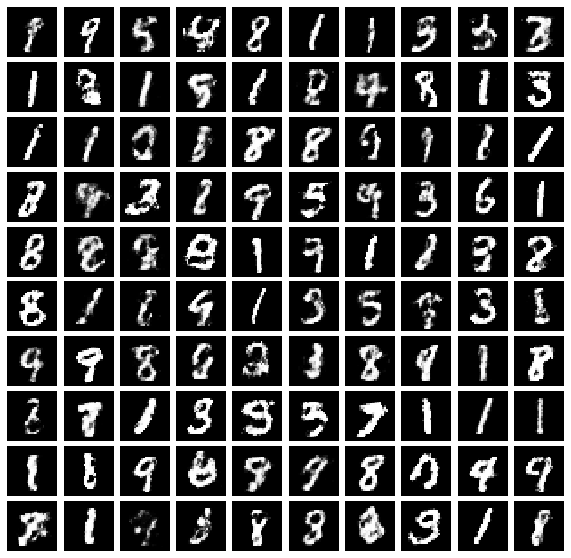

Iter: 56000
D loss: 0.7007
G_loss: 2.207
KL Div: 0.3337
Reverse KL Div: 0.3941



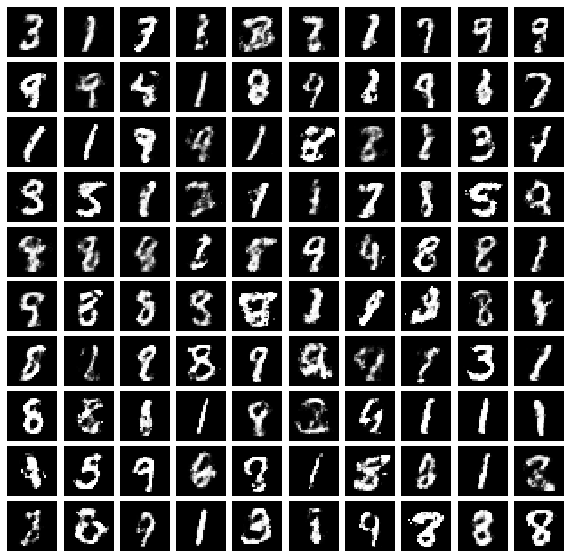

Iter: 57000
D loss: 0.7365
G_loss: 2.624
KL Div: 0.5217
Reverse KL Div: 0.6197



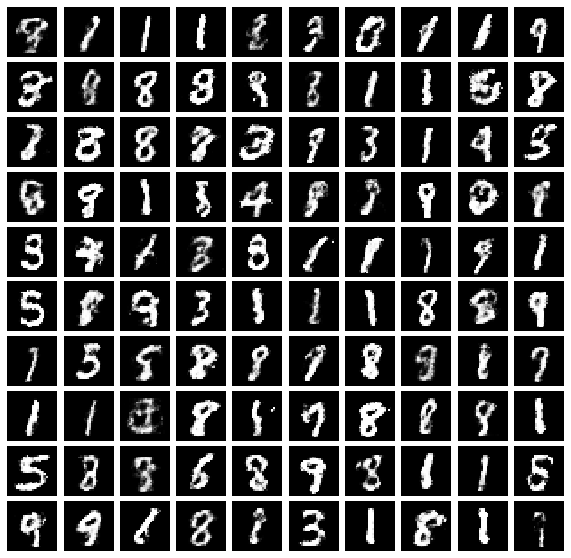

Iter: 58000
D loss: 0.5625
G_loss: 2.321
KL Div: 0.4554
Reverse KL Div: 0.5135



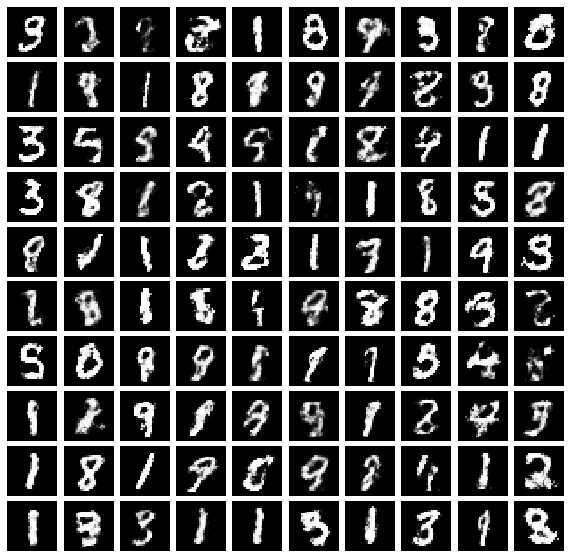

Iter: 59000
D loss: 0.7514
G_loss: 2.312
KL Div: 0.3692
Reverse KL Div: 0.4184



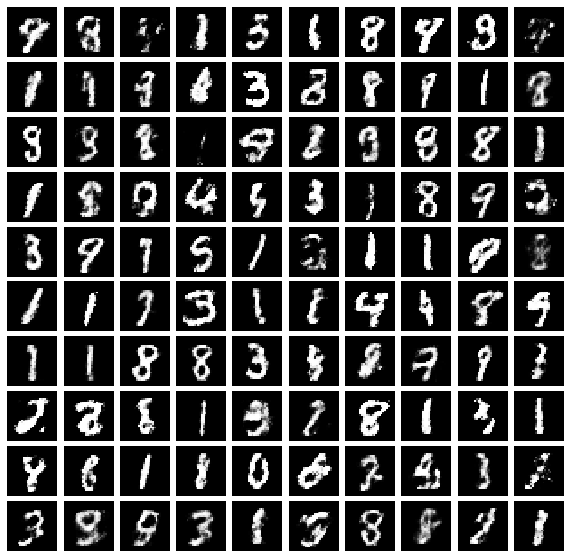

Iter: 60000
D loss: 0.5845
G_loss: 2.268
KL Div: 0.3787
Reverse KL Div: 0.5268



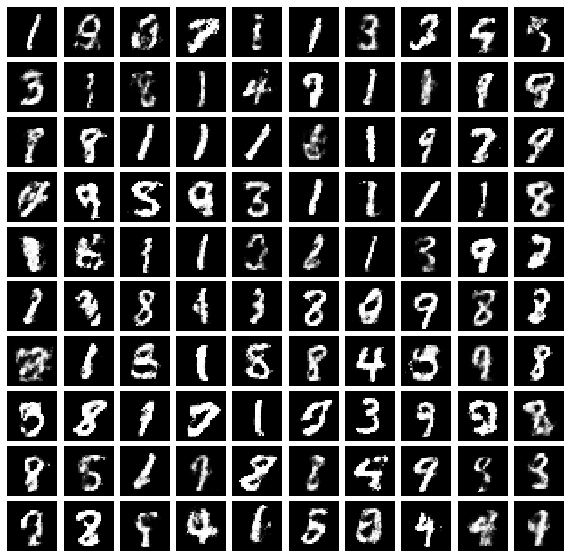

Iter: 61000
D loss: 0.6142
G_loss: 2.424
KL Div: 0.4474
Reverse KL Div: 0.4589



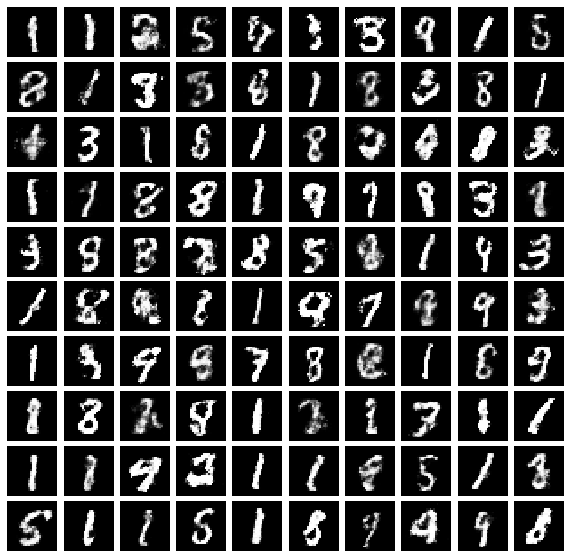

Iter: 62000
D loss: 0.6019
G_loss: 2.379
KL Div: 0.4266
Reverse KL Div: 1.154



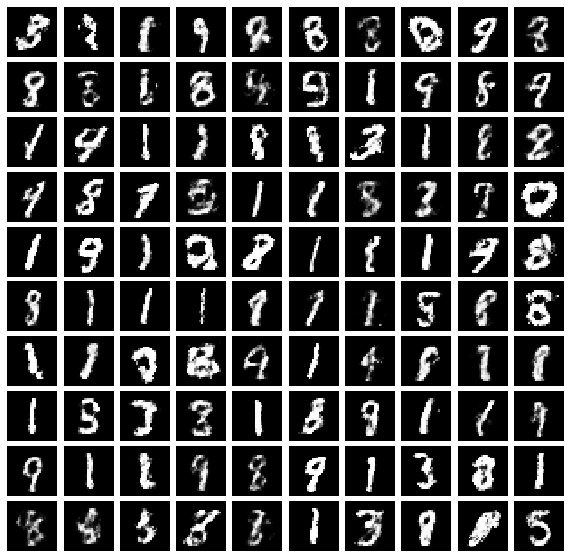

Iter: 63000
D loss: 0.622
G_loss: 2.361
KL Div: 0.5176
Reverse KL Div: 1.29



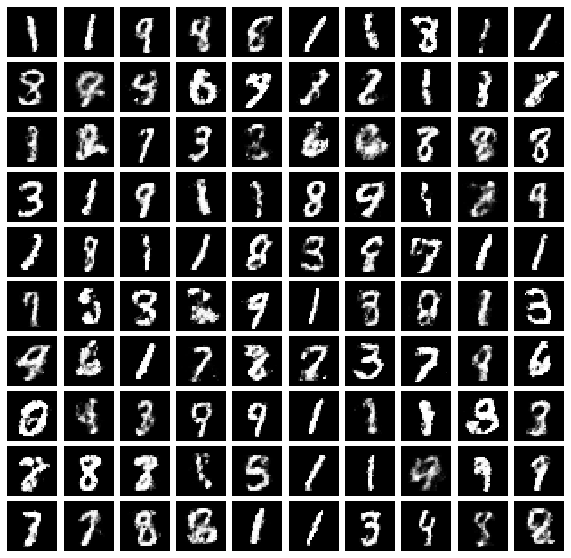

Iter: 64000
D loss: 0.6382
G_loss: 2.107
KL Div: 0.4364
Reverse KL Div: 0.5258



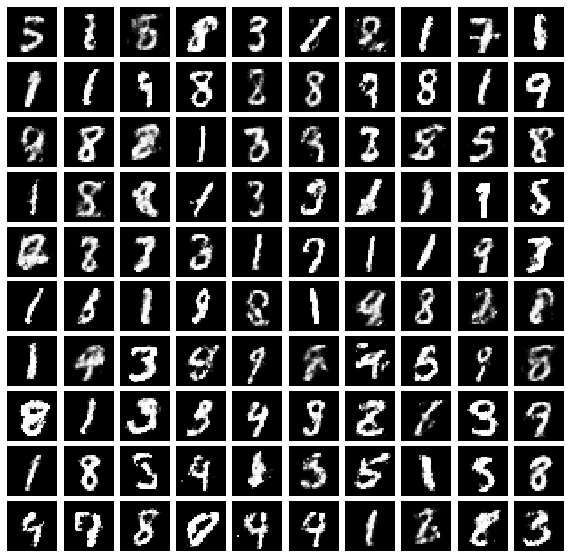

Iter: 65000
D loss: 0.5915
G_loss: 1.999
KL Div: 0.5269
Reverse KL Div: 0.6767



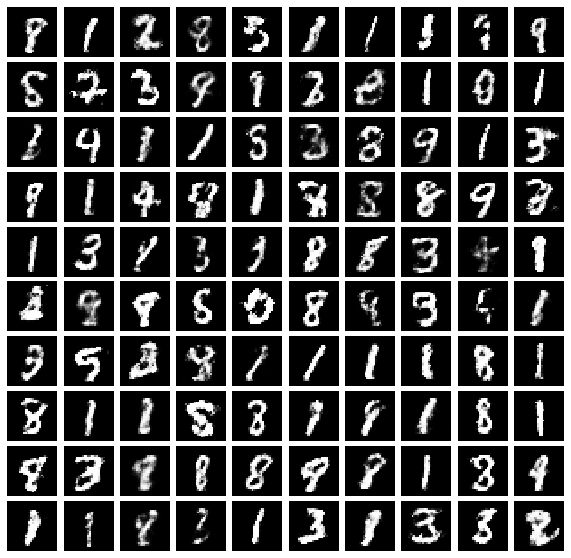

Iter: 66000
D loss: 0.6666
G_loss: 2.347
KL Div: 0.5112
Reverse KL Div: 0.6161



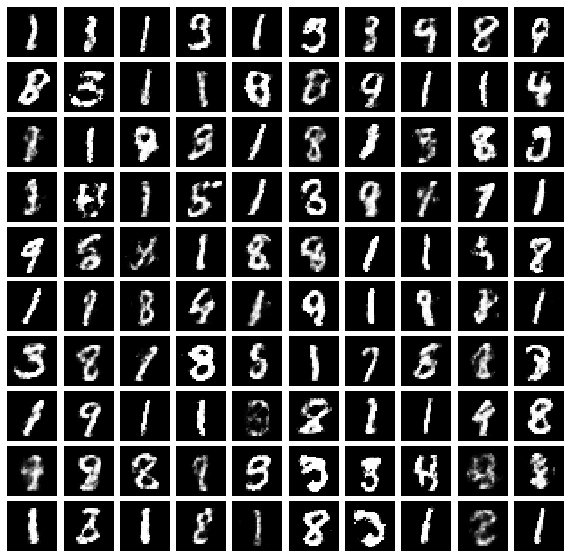

Iter: 67000
D loss: 0.5628
G_loss: 2.265
KL Div: 0.3318
Reverse KL Div: 0.3363



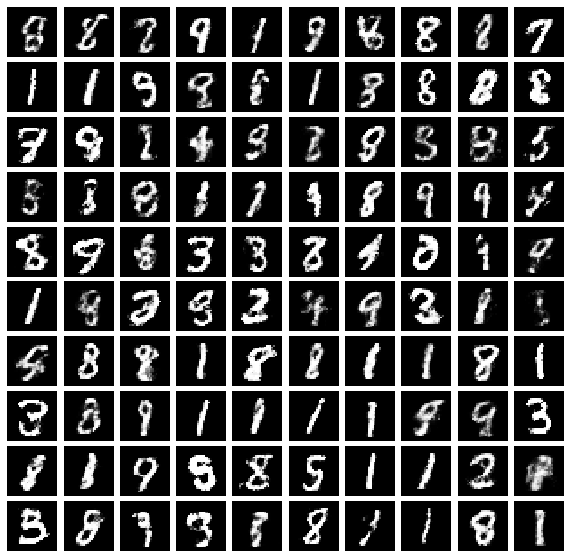

Iter: 68000
D loss: 0.6647
G_loss: 2.407
KL Div: 0.4149
Reverse KL Div: 1.126



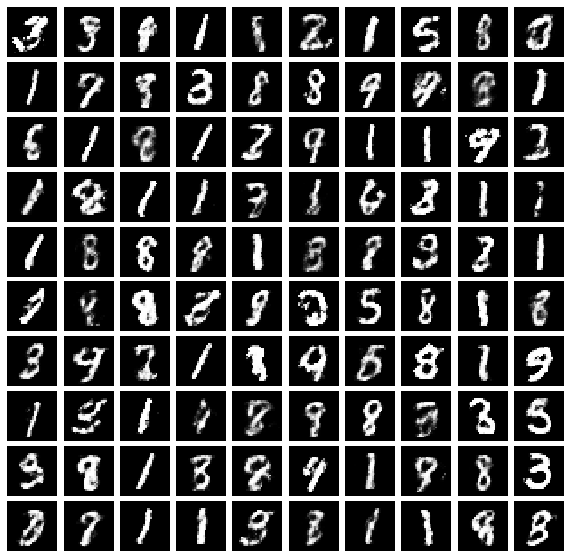

Iter: 69000
D loss: 0.5776
G_loss: 2.145
KL Div: 0.467
Reverse KL Div: 1.181



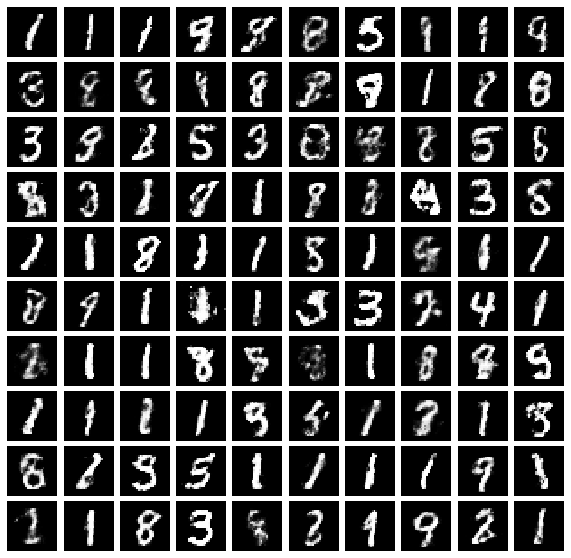

Iter: 70000
D loss: 0.5709
G_loss: 2.461
KL Div: 0.5109
Reverse KL Div: 0.6036



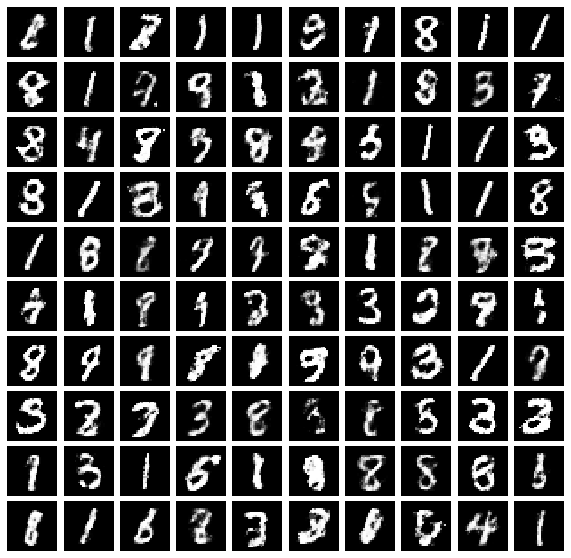

Iter: 71000
D loss: 0.5191
G_loss: 2.294
KL Div: 0.4203
Reverse KL Div: 0.4328



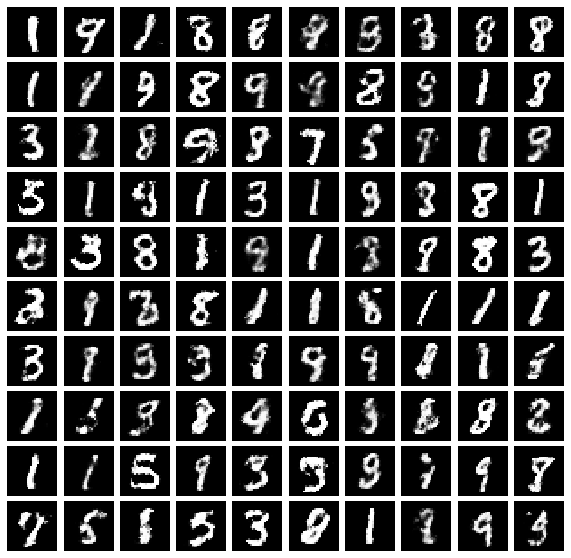

Iter: 72000
D loss: 0.7034
G_loss: 2.435
KL Div: 0.4918
Reverse KL Div: 0.5759



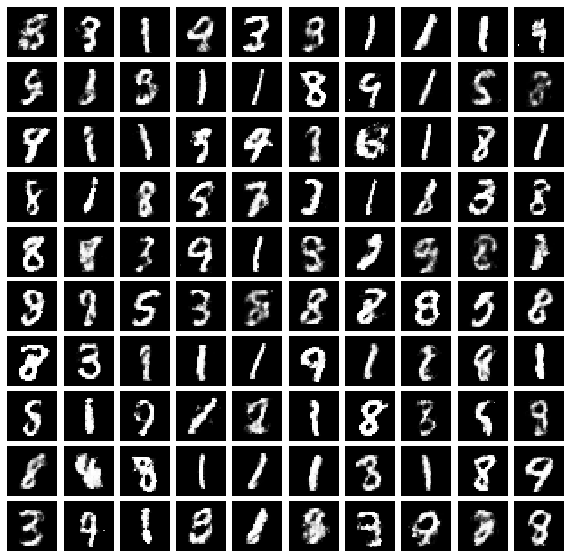

Iter: 73000
D loss: 0.6147
G_loss: 2.74
KL Div: 0.4274
Reverse KL Div: 0.5597



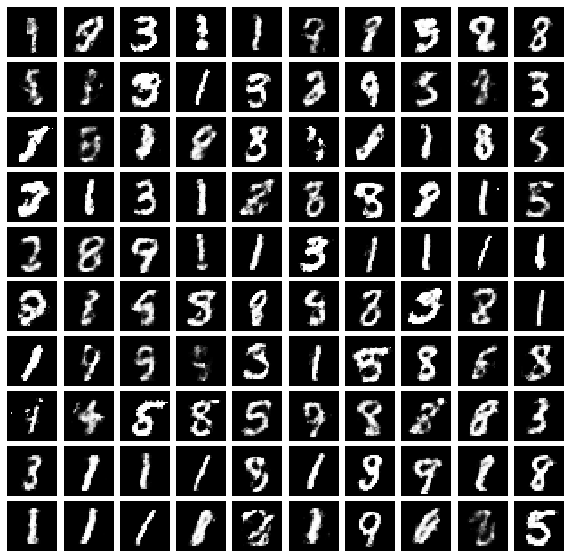

Iter: 74000
D loss: 0.559
G_loss: 2.502
KL Div: 0.5134
Reverse KL Div: 1.295



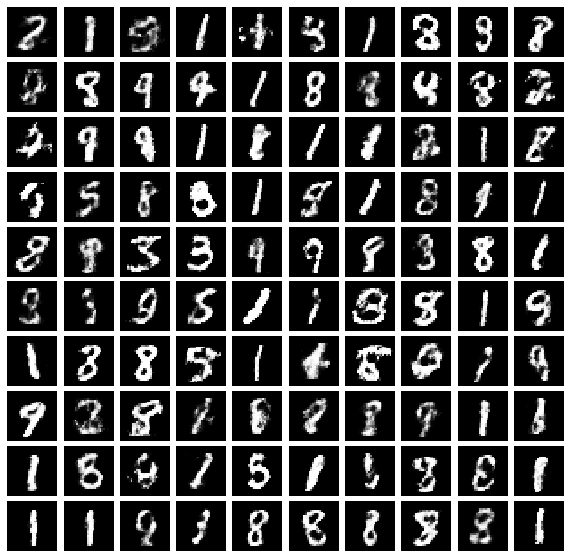

Iter: 75000
D loss: 0.5533
G_loss: 2.174
KL Div: 0.4994
Reverse KL Div: 0.6448



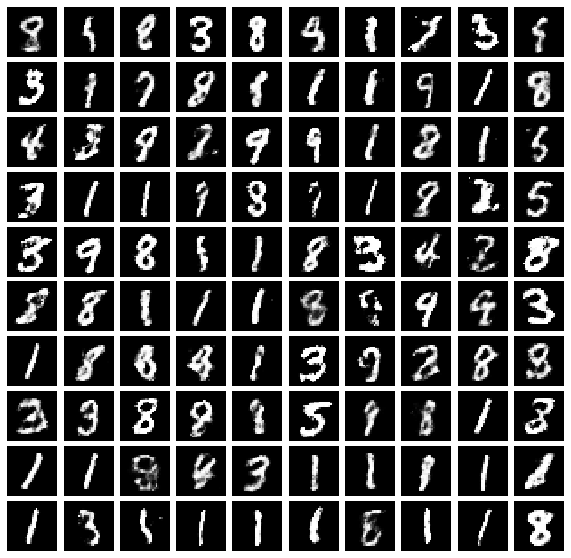

Iter: 76000
D loss: 0.5558
G_loss: 2.659
KL Div: 0.5167
Reverse KL Div: 0.5963



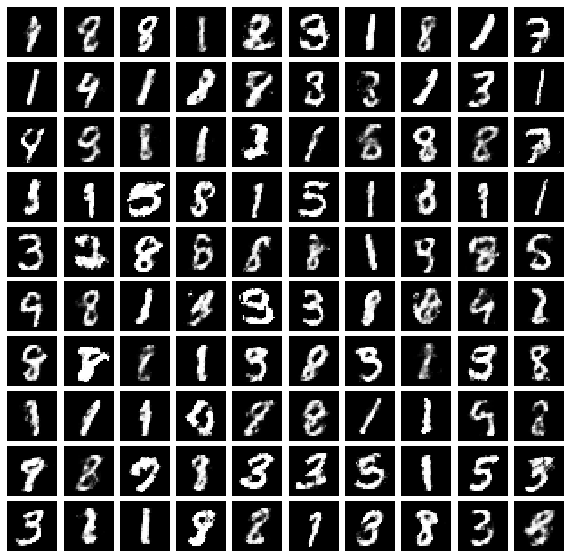

Iter: 77000
D loss: 0.4769
G_loss: 2.652
KL Div: 0.5462
Reverse KL Div: 1.258



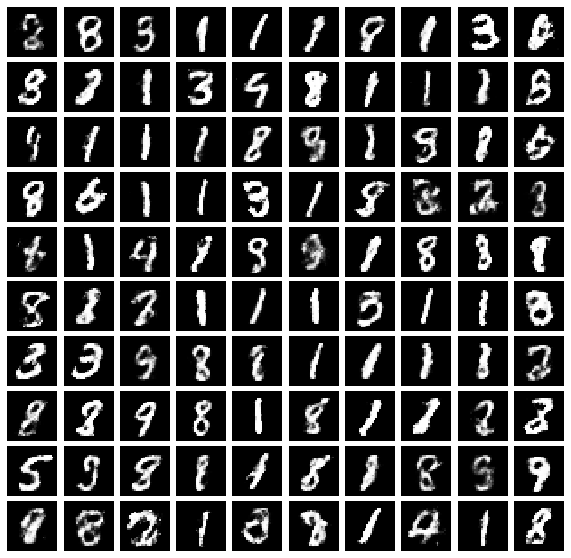

Iter: 78000
D loss: 0.4983
G_loss: 2.451
KL Div: 0.5162
Reverse KL Div: 0.6681



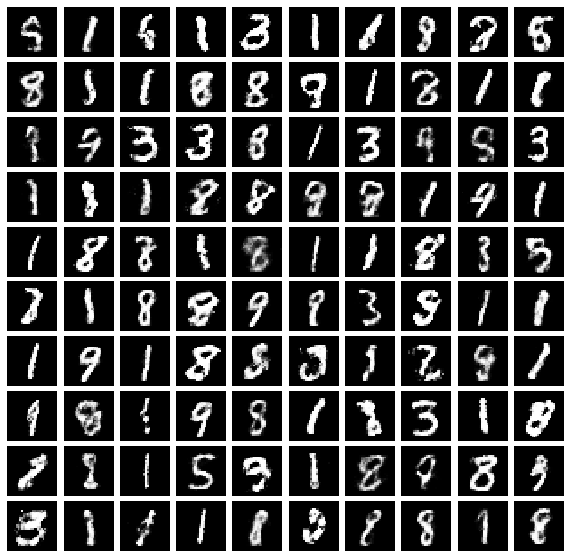

Iter: 79000
D loss: 0.5678
G_loss: 2.528
KL Div: 0.5698
Reverse KL Div: 0.6801



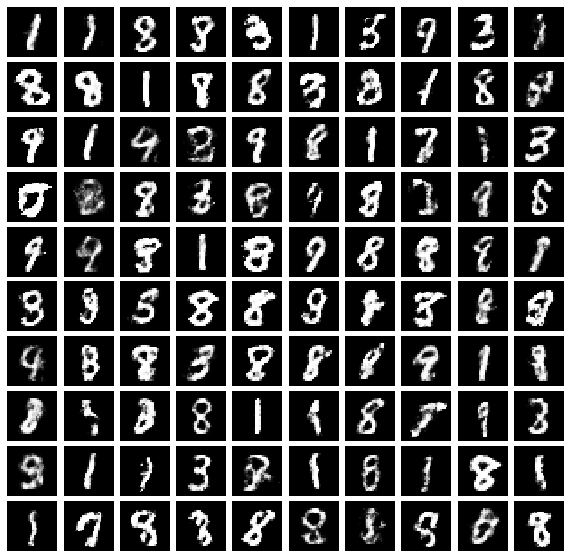

Iter: 80000
D loss: 0.6843
G_loss: 2.645
KL Div: 0.5522
Reverse KL Div: 0.7174



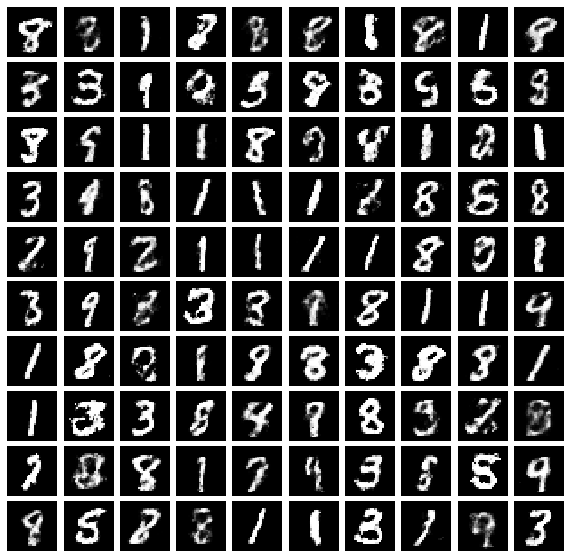

Iter: 81000
D loss: 0.5546
G_loss: 2.164
KL Div: 0.506
Reverse KL Div: 1.268



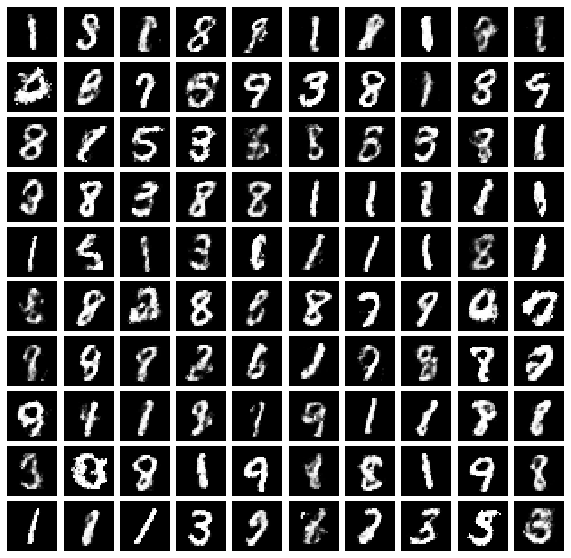

Iter: 82000
D loss: 0.5851
G_loss: 2.544
KL Div: 0.4747
Reverse KL Div: 0.5091



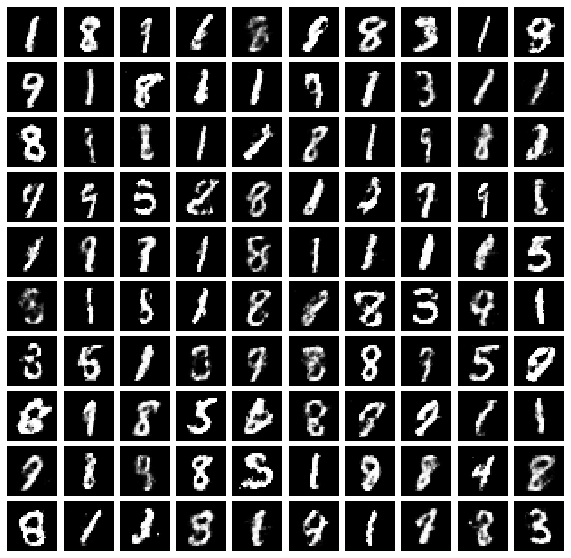

Iter: 83000
D loss: 0.4462
G_loss: 2.554
KL Div: 0.4591
Reverse KL Div: 0.5215



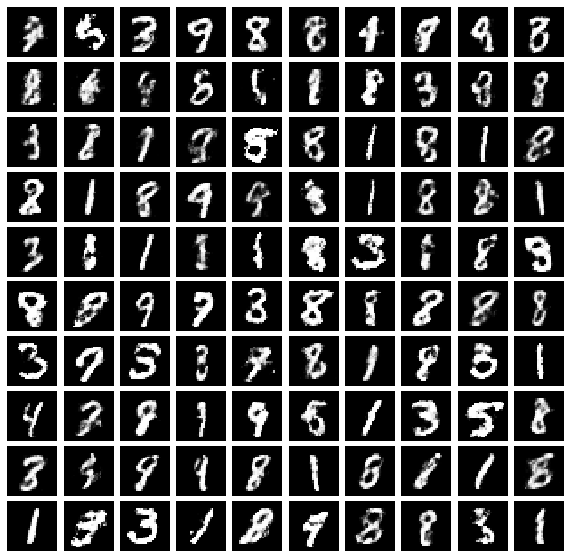

Iter: 84000
D loss: 0.5674
G_loss: 2.645
KL Div: 0.541
Reverse KL Div: 0.613



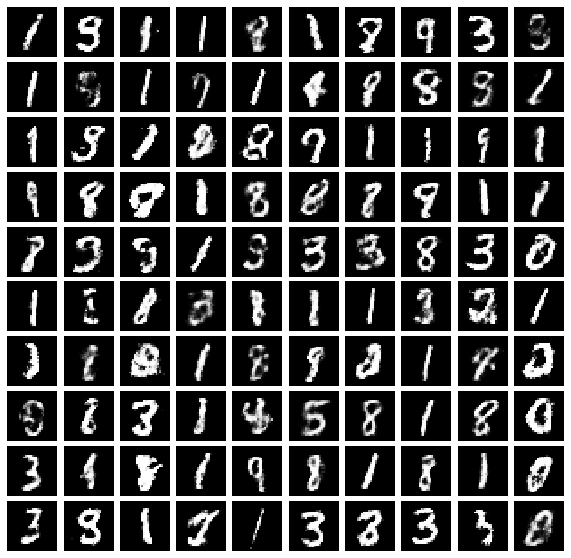

Iter: 85000
D loss: 0.6079
G_loss: 2.592
KL Div: 0.6119
Reverse KL Div: 0.7869



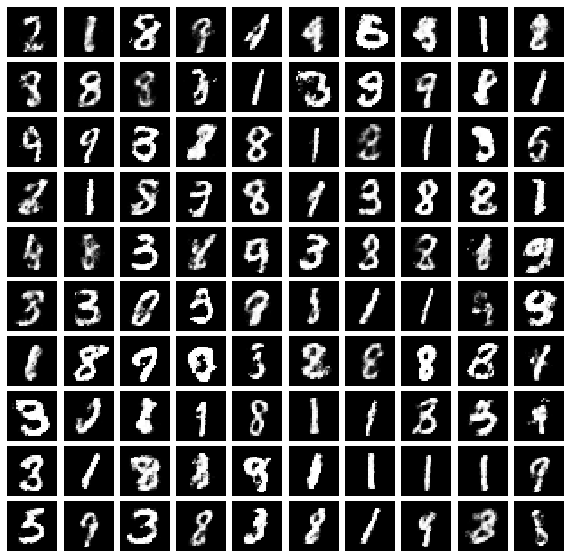

Iter: 86000
D loss: 0.5812
G_loss: 2.541
KL Div: 0.5534
Reverse KL Div: 0.7722



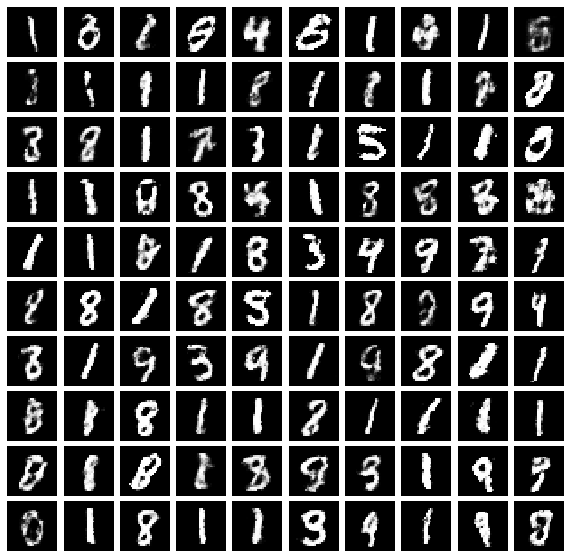

Iter: 87000
D loss: 0.5146
G_loss: 2.308
KL Div: 0.5085
Reverse KL Div: 1.285



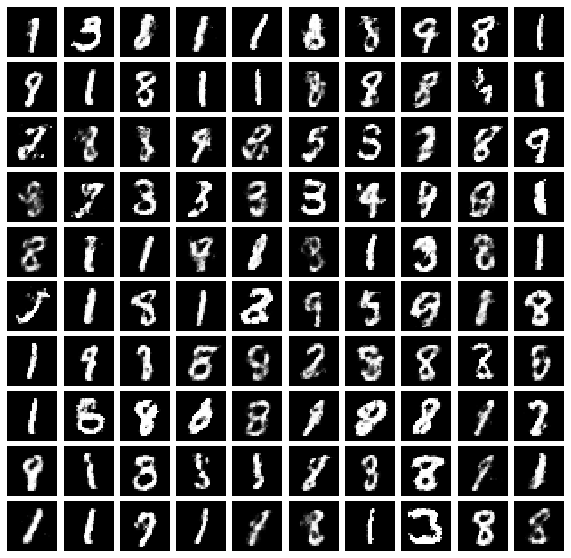

Iter: 88000
D loss: 0.5823
G_loss: 2.611
KL Div: 0.7789
Reverse KL Div: 1.709



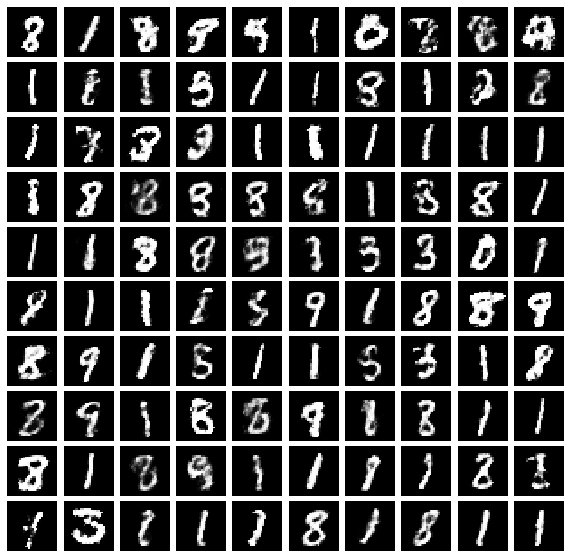

Iter: 89000
D loss: 0.4543
G_loss: 2.712
KL Div: 0.5457
Reverse KL Div: 0.7319



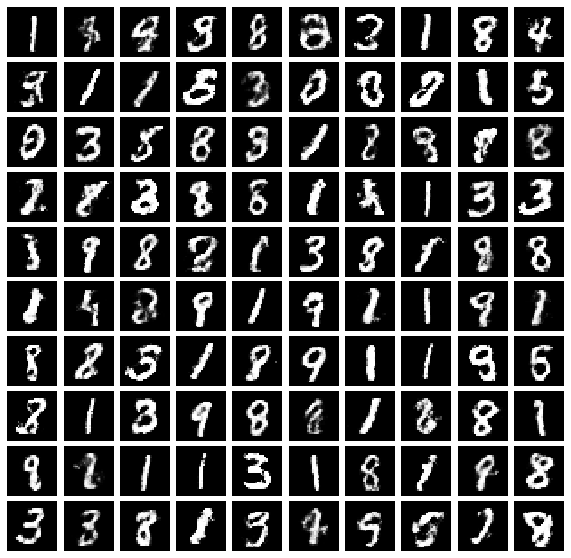

Iter: 90000
D loss: 0.5689
G_loss: 2.517
KL Div: 0.4643
Reverse KL Div: 0.5523



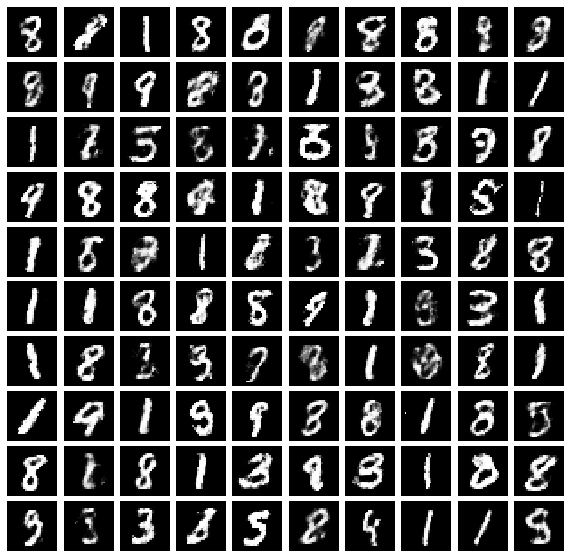

Iter: 91000
D loss: 0.5162
G_loss: 2.805
KL Div: 0.7072
Reverse KL Div: 0.8834



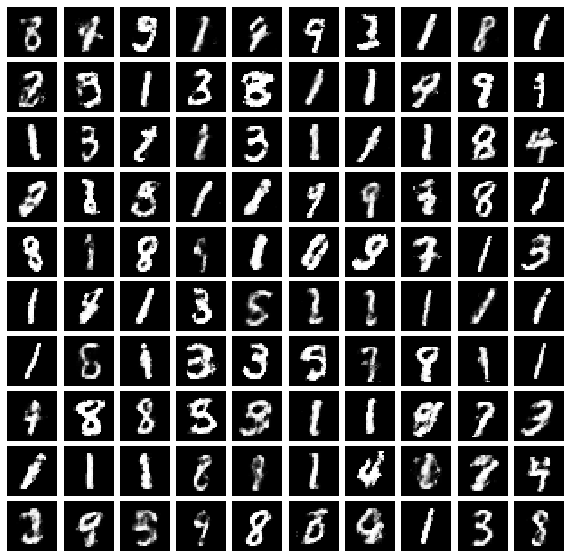

Iter: 92000
D loss: 0.4271
G_loss: 2.892
KL Div: 0.7198
Reverse KL Div: 2.132



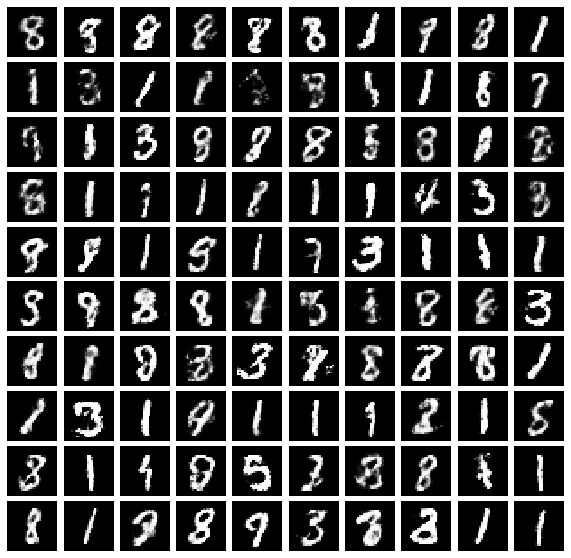

Iter: 93000
D loss: 0.5029
G_loss: 2.456
KL Div: 0.6634
Reverse KL Div: 0.7551



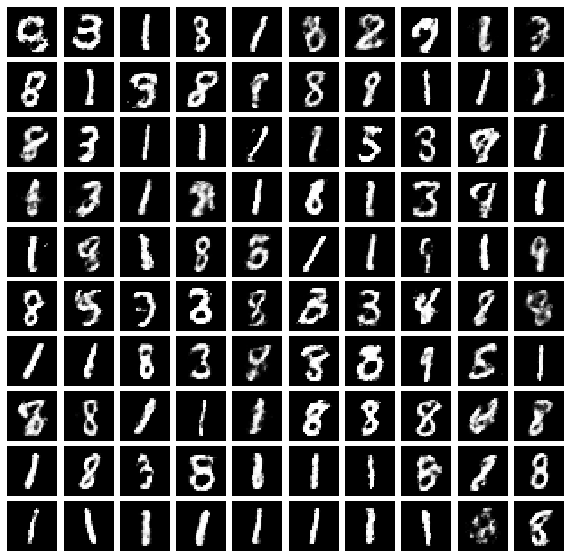

Iter: 94000
D loss: 0.5195
G_loss: 2.791
KL Div: 0.5985
Reverse KL Div: 0.7015



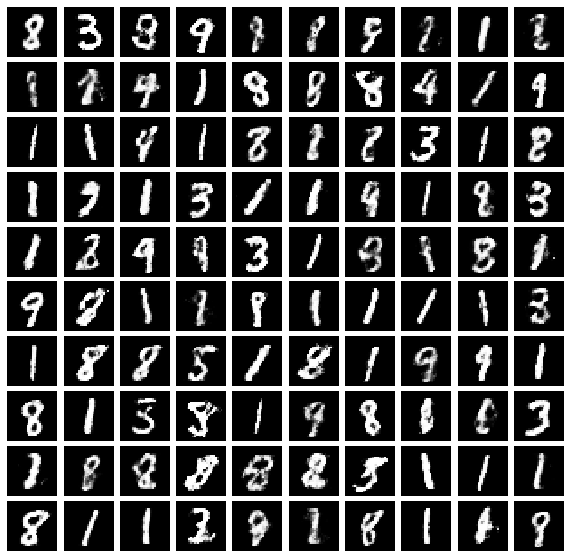

Iter: 95000
D loss: 0.5391
G_loss: 2.725
KL Div: 0.723
Reverse KL Div: 1.562



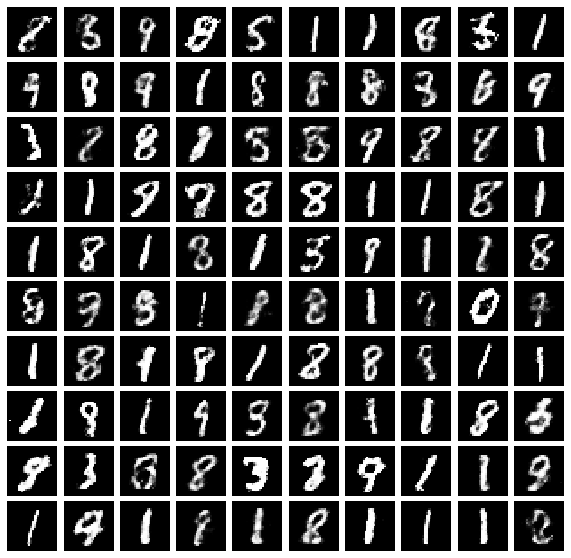

Iter: 96000
D loss: 0.47
G_loss: 2.508
KL Div: 0.5442
Reverse KL Div: 0.6638



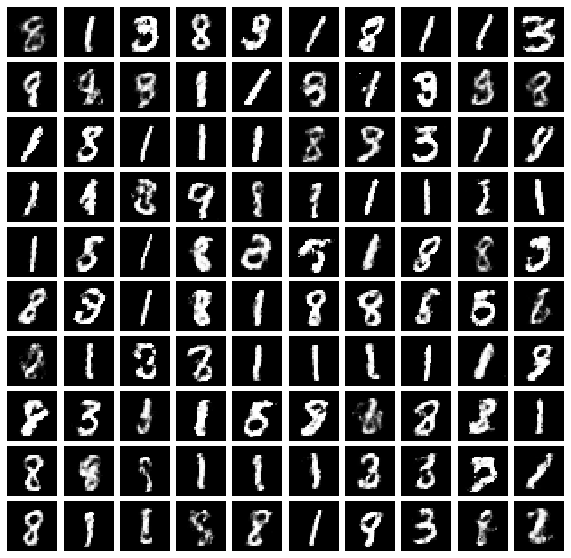

Iter: 97000
D loss: 0.4446
G_loss: 3.175
KL Div: 0.6318
Reverse KL Div: 0.7685



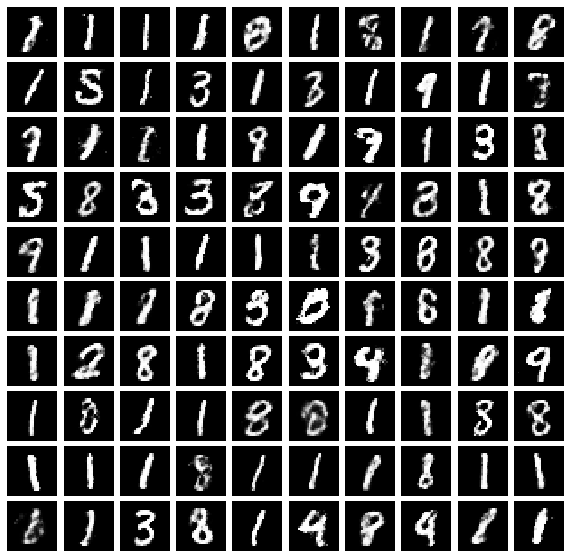

Iter: 98000
D loss: 0.4916
G_loss: 3.327
KL Div: 0.7417
Reverse KL Div: 1.501



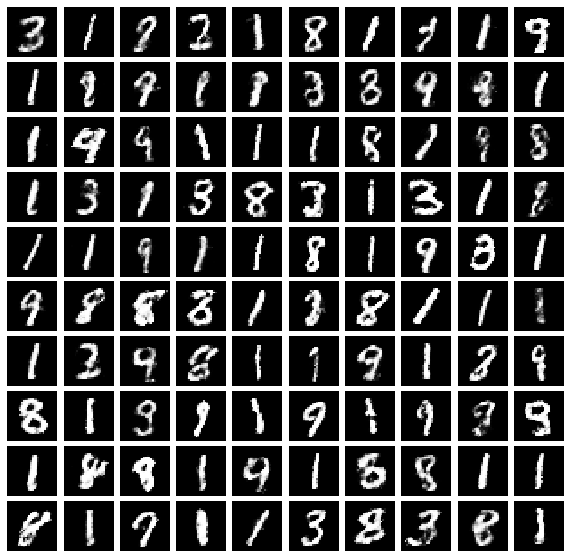

Iter: 99000
D loss: 0.5772
G_loss: 2.66
KL Div: 0.709
Reverse KL Div: 0.885



In [0]:
i = 0
g_losses, d_losses, kls, rev_kls, pds, mcs = [], [], [], [], [], []
for it in range(100000):
    if it % 1000 == 0:
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(100, Z_dim)})
        
        fig = plot(samples)
        plt.show(fig)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        
    X_mb, _ = mnist.train.next_batch(mb_size)

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    if it % 1000 == 0:
        kl_samples = sess.run(G_sample, feed_dict={Z: sample_Z(200, Z_dim)})
        kl, rev_kl, pd, mc = kl_divergence(kl_samples)
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print('KL Div: {:.4}'.format(kl))
        print('Reverse KL Div: {:.4}'.format(rev_kl))
        g_losses.append(D_loss_curr)
        d_losses.append(G_loss_curr)
        kls.append(kl)
        rev_kls.append(rev_kl)
        pds.append(pd)
        mcs.append(mc)
        print()

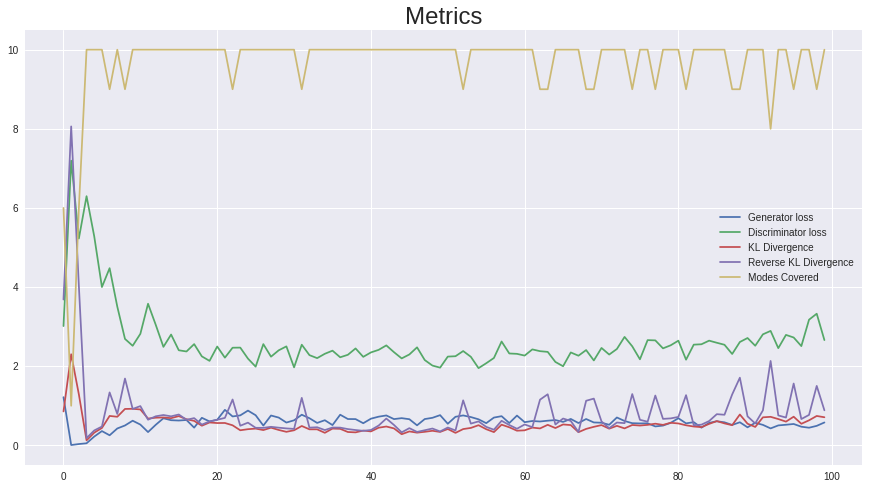

In [0]:
fig = plt.figure(figsize=(15,8))


for (metric, label) in zip([g_losses, d_losses, kls, rev_kls, mcs], ['Generator loss', 'Discriminator loss', 'KL Divergence', 'Reverse KL Divergence', 'Modes Covered']):
  
  plt.plot(metric, label=label)
  plt.title('Metrics', fontsize=24)
  plt.legend()

plt.show()

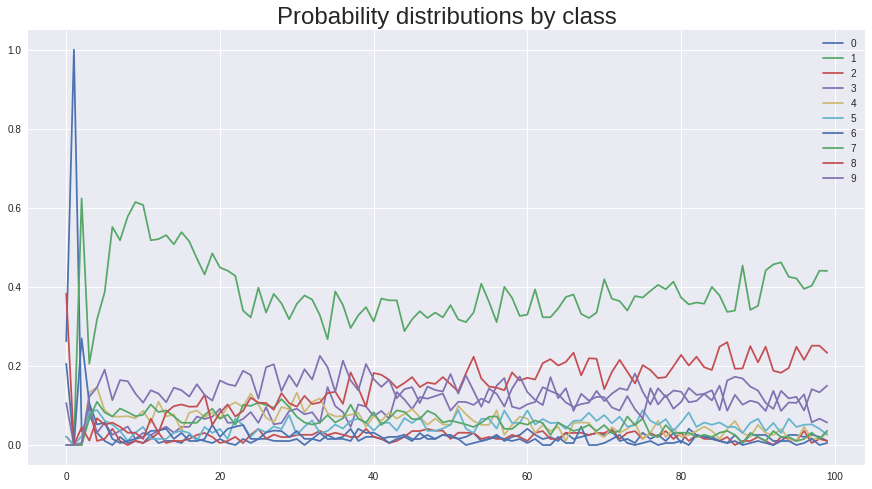

In [0]:
# plot probability distributions

fig = plt.figure(figsize=(15,8))

for (digit, label) in zip(np.array(pds).T, range(10)):
  
  plt.plot(digit, label=label)
  plt.title('Probability distributions by class', fontsize=24)
  plt.legend()

plt.show()